### Pearson Correlation Analysis

In [7]:
# imports
import pandas as pd
import numpy as np

In [11]:
# Load data
data_path = '/Users/fsl/Documents/GitHub/CPSC540ParlettPelleriti/FinalProject/data/concat_data.csv'
df = pd.read_csv(data_path)

# Convert the 'timestamp' column to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Set the datetime column as the index
df.set_index("timestamp", inplace=True)


/var/folders/ns/qk2_mvqx6w3bpj6wspgtt2c40000gn/T/ipykernel_64677/3260978803.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["timestamp"] = pd.to_datetime(df["timestamp"])


In [12]:
# Encode fear_greed_classification column numerically
# Mapping for encoding
encoding_map = {
    "Extreme Fear": -2,
    "Fear": -1,
    "Neutral": 0,
    "Greed": 1,
    "Extreme Greed": 2,
    np.nan: 0  # Default for NaN 
}
df["fear_greed_classification"] = df["fear_greed_classification"].map(encoding_map).fillna(0)

In [13]:
df.head(3)

,fear_greed_value,fear_greed_classification,exchange_volume_btc,perp_funding_rate_btc,m2_supply,m2_supply_month_pct_change,gld_etf_price_gold,futures_price_gold,price_btc,dxy_usd_index
timestamp,,,,,,,,,,
2018-02-01,30.0,-1,33564.76431,NaN,13907.3,0.274709,128.070007,1344.300049,9170.540039,88.67
2018-02-02,15.0,-2,49971.62698,NaN,13907.3,0.274709,126.389999,1333.699951,8830.750000,89.19
2018-02-03,40.0,-1,28725.00074,NaN,13907.3,0.274709,126.496666,1333.466634,9174.910156,89.19


In [25]:
import pandas as pd
import numpy as np

# First resample to weekly for base metrics
weekly_metrics = pd.DataFrame()

# Fear & Greed Metrics
weekly_metrics['fg_avg'] = df['fear_greed_value'].resample('W').mean()
weekly_metrics['fg_range'] = df['fear_greed_value'].resample('W').max() - df['fear_greed_value'].resample('W').min()
weekly_metrics['fg_class_avg'] = df['fear_greed_classification'].resample('W').mean()
weekly_metrics['fg_extreme_pct'] = df['fear_greed_classification'].apply(lambda x: abs(x) == 2).resample('W').mean()

# Create lagged versions
for lag in [1, 2, 4]:
    weekly_metrics[f'fg_avg_lag{lag}w'] = weekly_metrics['fg_avg'].shift(lag)
    weekly_metrics[f'fg_class_avg_lag{lag}w'] = weekly_metrics['fg_class_avg'].shift(lag)

# Volume Metrics
weekly_metrics['volume_total'] = df['exchange_volume_btc'].resample('W').sum()
weekly_metrics['volume_avg'] = df['exchange_volume_btc'].resample('W').mean()
weekly_metrics['volume_std'] = df['exchange_volume_btc'].resample('W').std()
weekly_metrics['volume_pct_change'] = weekly_metrics['volume_total'].pct_change()
weekly_metrics['volume_ma4w'] = weekly_metrics['volume_total'].rolling(window=4).mean()

# Funding Rate Metrics
weekly_metrics['funding_avg'] = df['perp_funding_rate_btc'].resample('W').mean()
weekly_metrics['funding_range'] = df['perp_funding_rate_btc'].resample('W').max() - df['perp_funding_rate_btc'].resample('W').min()
weekly_metrics['funding_std'] = df['perp_funding_rate_btc'].resample('W').std()
weekly_metrics['funding_cum'] = df['perp_funding_rate_btc'].resample('W').sum()

for lag in [1, 2, 4]:
    weekly_metrics[f'funding_avg_lag{lag}w'] = weekly_metrics['funding_avg'].shift(lag)

# M2 Supply Metrics - corrected for monthly data that's repeated daily
# First get the true monthly values (taking first day of each month since all days in month are same)
monthly_m2 = df['m2_supply'].resample('M').first()  # or .last(), doesn't matter since all days same

# Calculate additional month-over-month changes
# Note: m2_supply_month_pct_change is already available in original data
monthly_metrics = pd.DataFrame()
monthly_metrics['m2_level'] = monthly_m2
monthly_metrics['m2_mom'] = df['m2_supply_month_pct_change'].resample('M').first()  # getting original monthly changes
monthly_metrics['m2_3m_change'] = monthly_m2.pct_change(3)
monthly_metrics['m2_6m_change'] = monthly_m2.pct_change(6)
monthly_metrics['m2_yoy_change'] = monthly_m2.pct_change(12)

# Now resample to weekly frequency with forward fill
# This ensures each week in a month gets the same M2 values
weekly_metrics['m2_level'] = monthly_metrics['m2_level'].resample('W').ffill()
weekly_metrics['m2_mom'] = monthly_metrics['m2_mom'].resample('W').ffill()
weekly_metrics['m2_3m_change'] = monthly_metrics['m2_3m_change'].resample('W').ffill()
weekly_metrics['m2_6m_change'] = monthly_metrics['m2_6m_change'].resample('W').ffill()
weekly_metrics['m2_yoy_change'] = monthly_metrics['m2_yoy_change'].resample('W').ffill()

# Gold Metrics (both ETF and Futures)
for gold_col in ['gld_etf_price_gold', 'futures_price_gold']:
    prefix = 'gold_etf' if 'etf' in gold_col else 'gold_fut'
    weekly_metrics[f'{prefix}_avg'] = df[gold_col].resample('W').mean()
    weekly_metrics[f'{prefix}_return'] = df[gold_col].resample('W').last().pct_change()
    weekly_metrics[f'{prefix}_std'] = df[gold_col].resample('W').std()
    weekly_metrics[f'{prefix}_range'] = df[gold_col].resample('W').max() - df[gold_col].resample('W').min()
    
    for lag in [1, 2, 4]:
        weekly_metrics[f'{prefix}_return_lag{lag}w'] = weekly_metrics[f'{prefix}_return'].shift(lag)

# Gold contango (futures premium over spot)
weekly_metrics['gold_future_premium'] = (weekly_metrics['gold_fut_avg'] / weekly_metrics['gold_etf_avg'] - 1) * 100

# DXY Metrics
weekly_metrics['dxy_avg'] = df['dxy_usd_index'].resample('W').mean()
weekly_metrics['dxy_return'] = df['dxy_usd_index'].resample('W').last().pct_change()
weekly_metrics['dxy_std'] = df['dxy_usd_index'].resample('W').std()
weekly_metrics['dxy_4w_change'] = df['dxy_usd_index'].resample('W').last().pct_change(4)

for lag in [1, 2, 4]:
    weekly_metrics[f'dxy_return_lag{lag}w'] = weekly_metrics['dxy_return'].shift(lag)

# BTC Price Metrics (dependent variable)
weekly_metrics['btc_close'] = df['price_btc'].resample('W').last()
weekly_metrics['btc_return'] = weekly_metrics['btc_close'].pct_change()
weekly_metrics['btc_range'] = df['price_btc'].resample('W').max() - df['price_btc'].resample('W').min()
weekly_metrics['btc_std'] = df['price_btc'].resample('W').std()
weekly_metrics['btc_return_2w'] = weekly_metrics['btc_close'].pct_change(2)
weekly_metrics['btc_return_4w'] = weekly_metrics['btc_close'].pct_change(4)

# Relative/Ratio Metrics
weekly_metrics['gold_btc_ratio'] = weekly_metrics['gold_etf_avg'] / weekly_metrics['btc_close']
weekly_metrics['volume_price_ratio'] = weekly_metrics['volume_total'] / weekly_metrics['btc_close']
weekly_metrics['funding_volume_ratio'] = weekly_metrics['funding_cum'] / weekly_metrics['volume_total']

# Drop any columns where all values are NA
weekly_metrics = weekly_metrics.dropna(axis=1, how='all')

/var/folders/ns/qk2_mvqx6w3bpj6wspgtt2c40000gn/T/ipykernel_64677/721416307.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_m2 = df['m2_supply'].resample('M').first()  # or .last(), doesn't matter since all days same
/var/folders/ns/qk2_mvqx6w3bpj6wspgtt2c40000gn/T/ipykernel_64677/721416307.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_metrics['m2_mom'] = df['m2_supply_month_pct_change'].resample('M').first()  # getting original monthly changes
/var/folders/ns/qk2_mvqx6w3bpj6wspgtt2c40000gn/T/ipykernel_64677/721416307.py:43: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_metrics['m2_3m_change'] = monthly_m2.pct_change(3)
/var/folders/ns/qk2_mvqx6w3b

In [18]:
weekly_metrics

,fg_avg,fg_range,fg_class_avg,fg_extreme_pct,fg_avg_lag1w,fg_class_avg_lag1w,fg_avg_lag2w,fg_class_avg_lag2w,fg_avg_lag4w,fg_class_avg_lag4w,...,dxy_return_lag4w,btc_close,btc_return,btc_range,btc_std,btc_return_2w,btc_return_4w,gold_btc_ratio,volume_price_ratio,funding_volume_ratio
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-04,27.250000,25.0,-1.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,8277.009766,NaN,897.900390,422.805342,NaN,NaN,0.015330,17.430896,0.000000e+00
2018-02-11,30.571429,46.0,-1.142857,0.285714,27.250000,-1.500000,NaN,NaN,NaN,NaN,...,NaN,8129.970215,-0.017765,1781.710449,620.710439,NaN,NaN,0.015406,41.918271,0.000000e+00
2018-02-18,58.142857,39.0,0.428571,0.000000,30.571429,-1.142857,27.250000,-1.500000,NaN,NaN,...,NaN,10551.799800,0.297889,2514.390630,901.626832,0.274832,NaN,0.012058,29.555438,0.000000e+00
2018-02-25,48.857143,43.0,-0.285714,0.000000,58.142857,0.428571,30.571429,-1.142857,NaN,NaN,...,NaN,9664.730469,-0.084068,1738.969731,684.426602,0.188778,NaN,0.013061,36.278625,0.000000e+00
2018-03-04,43.857143,19.0,-0.571429,0.000000,48.857143,-0.285714,58.142857,0.428571,27.250000,-1.500000,...,NaN,11512.599610,0.191197,1145.899410,468.996856,0.091056,0.390913,0.010886,15.979970,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-10,73.571429,8.0,1.285714,0.285714,74.142857,1.285714,71.333333,0.857143,45.428571,-0.285714,...,0.003609,80474.187500,0.170685,12662.679690,4460.054727,0.184676,0.280389,0.003088,4.068946,1.769172e-09
2024-11-17,83.428571,14.0,2.000000,1.000000,73.571429,1.285714,74.142857,1.285714,67.857143,0.857143,...,0.005831,89845.851560,0.116456,3815.578120,1466.809041,0.307018,0.302082,0.002657,4.648298,1.991802e-09
2024-11-24,86.428571,14.0,2.000000,1.000000,83.428571,2.000000,73.571429,1.285714,71.333333,0.857143,...,0.007440,98013.820310,0.090911,8455.023430,3368.199807,0.217954,0.442880,0.002504,3.099408,3.053698e-09


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Optional

def plot_btc_correlations(weekly_metrics: pd.DataFrame, 
                         target_cols: List[str] = ['btc_return', 'btc_close'],
                         min_correlation: float = 0.2,
                         figsize: tuple = (15, 10)) -> None:
    """
    Generate correlation heatmap and bar plots for BTC metrics.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing all weekly metrics
    target_cols : List[str]
        BTC metrics to analyze correlations against
    min_correlation : float
        Minimum absolute correlation to display (filters noise)
    figsize : tuple
        Size of the figure (width, height)
    """
    
    # Create correlation matrix
    corr_matrix = weekly_metrics.corr()
    
    # For each target metric
    for target in target_cols:
        # Get correlations for target
        correlations = corr_matrix[target].sort_values(ascending=False)
        
        # Filter out self-correlations and low correlations
        correlations = correlations[
            (abs(correlations) >= min_correlation) & 
            (correlations.index != target)
        ]
        
        # Split into positive and negative correlations
        pos_corr = correlations[correlations > 0]
        neg_corr = correlations[correlations < 0]
        
        # Create the figure
        plt.figure(figsize=figsize)
        
        # Plot positive correlations
        plt.subplot(2, 1, 1)
        if not pos_corr.empty:
            plt.barh(range(len(pos_corr)), pos_corr.values, color='green', alpha=0.6)
            plt.yticks(range(len(pos_corr)), pos_corr.index)
        plt.title(f'Positive Correlations with {target}')
        plt.xlabel('Correlation Coefficient')
        plt.grid(True, alpha=0.3)
        
        # Plot negative correlations
        plt.subplot(2, 1, 2)
        if not neg_corr.empty:
            plt.barh(range(len(neg_corr)), neg_corr.values, color='red', alpha=0.6)
            plt.yticks(range(len(neg_corr)), neg_corr.index)
        plt.title(f'Negative Correlations with {target}')
        plt.xlabel('Correlation Coefficient')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

        # Print top correlations
        print(f"\nTop correlations with {target}:")
        print("\nPositive correlations:")
        for idx, val in pos_corr.head().items():
            print(f"{idx}: {val:.3f}")
        print("\nNegative correlations:")
        for idx, val in neg_corr.tail().items():
            print(f"{idx}: {val:.3f}")
        print("\n" + "="*50 + "\n")

def analyze_lagged_correlations(weekly_metrics: pd.DataFrame,
                              target: str = 'btc_return',
                              lag_cols: Optional[List[str]] = None) -> pd.DataFrame:
    """
    Analyze and display correlations for lagged variables.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing all weekly metrics
    target : str
        Target BTC metric to analyze correlations against
    lag_cols : List[str], optional
        Specific lagged columns to analyze. If None, finds all columns with 'lag' in name
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing lag correlations
    """
    if lag_cols is None:
        lag_cols = [col for col in weekly_metrics.columns if 'lag' in col]
    
    lag_corr = weekly_metrics[lag_cols].corrwith(weekly_metrics[target]).sort_values(ascending=False)
    
    # Plot lag correlations
    plt.figure(figsize=(12, 6))
    colors = ['green' if x >= 0 else 'red' for x in lag_corr.values]
    plt.bar(range(len(lag_corr)), lag_corr.values, color=colors, alpha=0.6)
    plt.xticks(range(len(lag_corr)), lag_corr.index, rotation=45, ha='right')
    plt.title(f'Lagged Variable Correlations with {target}')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return lag_corr

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

def plot_btc_correlation_heatmap(weekly_metrics: pd.DataFrame,
                                btc_metrics: List[str] = ['btc_return', 'btc_close', 'btc_std', 'btc_range'],
                                min_correlation: float = 0.2,
                                top_n: int = 5,
                                figsize: tuple = (12, 8)) -> None:
    """
    Generate a heatmap showing correlations between multiple BTC metrics and top correlated variables,
    with detailed breakdowns for each BTC metric.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing all weekly metrics
    btc_metrics : List[str]
        List of BTC-related metrics to analyze
    min_correlation : float
        Minimum absolute correlation to include a variable
    top_n : int
        Number of top correlations to show for each metric
    figsize : tuple
        Size of the figure (width, height)
    """
    
    # Calculate correlation matrix
    corr_matrix = weekly_metrics.corr()
    
    # Find variables with significant correlations to any BTC metric
    significant_vars = set()
    for btc_metric in btc_metrics:
        correlations = corr_matrix[btc_metric]
        significant = correlations[abs(correlations) >= min_correlation].index.tolist()
        significant_vars.update(significant)
    
    # Remove BTC metrics from significant vars
    significant_vars = [var for var in significant_vars 
                       if not any(btc_m in var for btc_m in btc_metrics)]
    
    # Sort variables by average absolute correlation
    avg_corr = []
    for var in significant_vars:
        mean_abs_corr = np.mean([abs(corr_matrix.loc[var, btc_m]) 
                                for btc_m in btc_metrics])
        avg_corr.append((var, mean_abs_corr))
    
    # Sort and take top 15 for heatmap
    significant_vars = [x[0] for x in sorted(avg_corr, 
                                           key=lambda x: x[1], 
                                           reverse=True)[:15]]
    
    # Create focused correlation matrix for heatmap
    focused_corr = corr_matrix.loc[significant_vars, btc_metrics]
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(focused_corr,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                center=0,
                vmin=-1,
                vmax=1,
                cbar_kws={'label': 'Correlation Coefficient'})
    
    plt.title('Cross-Correlation Heatmap: BTC Metrics vs Top Correlated Variables')
    plt.ylabel('Variables')
    plt.xlabel('BTC Metrics')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Print detailed breakdowns for each BTC metric
    print("\n=== Detailed Correlation Breakdown ===\n")
    for btc_metric in btc_metrics:
        # Get correlations for this metric
        correlations = corr_matrix[btc_metric]
        # Filter out self and other BTC metrics
        correlations = correlations[~correlations.index.str.contains('btc')]
        # Sort by absolute correlation
        sorted_corr = correlations.abs().sort_values(ascending=False)
        top_vars = sorted_corr.head(top_n).index
        
        print(f"\nTop {top_n} correlations for {btc_metric}:")
        print("-" * 50)
        for var in top_vars:
            corr_value = correlations[var]
            direction = "positive" if corr_value > 0 else "negative"
            print(f"{var:30} {corr_value:>8.3f} ({direction})")
            
            # Add interpretation for certain types of variables
            if 'lag' in var:
                print(f"    → Represents relationship with {var.split('lag')[0]}from "
                      f"{var.split('lag')[1].split('w')[0]} weeks ago")
            elif 'fg' in var:
                print("    → Fear & Greed indicator relationship")
            elif 'volume' in var:
                print("    → Trading volume relationship")
            elif 'funding' in var:
                print("    → Funding rate relationship")
        print()
    
    print("\nNote: Relationships show correlation, not causation. High correlation "
          "between current values and lagged/future values should be interpreted carefully "
          "considering the specific metrics involved.")

In [31]:
def plot_gold_btc_comparison(weekly_metrics, figsize=(15, 12)):
    """
    Create multiple plots comparing gold and bitcoin metrics over time.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing weekly metrics with datetime index
    figsize : tuple
        Size of the figure
    """
    fig, axs = plt.subplots(3, 1, figsize=figsize)
    
    # Plot 1: Normalized prices (both scaled to start at 100)
    ax = axs[0]
    btc_normalized = weekly_metrics['btc_close'] / weekly_metrics['btc_close'].iloc[0] * 100
    gold_normalized = weekly_metrics['gold_etf_avg'] / weekly_metrics['gold_etf_avg'].iloc[0] * 100
    
    ax.plot(weekly_metrics.index, btc_normalized, label='BTC', color='orange', linewidth=2)
    ax.plot(weekly_metrics.index, gold_normalized, label='Gold', color='goldenrod', linewidth=2)
    ax.set_title('Normalized Price Performance (Start = 100)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Gold/BTC Ratio over time
    ax = axs[1]
    ax.plot(weekly_metrics.index, weekly_metrics['gold_btc_ratio'], 
            color='purple', linewidth=2)
    ax.set_title('Gold/BTC Ratio Over Time')
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Rolling 30-day correlation
    ax = axs[2]
    rolling_corr = weekly_metrics['btc_close'].rolling(window=30).corr(
        weekly_metrics['gold_etf_avg']
    )
    ax.plot(weekly_metrics.index, rolling_corr, color='blue', linewidth=2)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax.set_title('30-Week Rolling Correlation between Gold and BTC')
    ax.set_ylim(-1, 1)
    ax.grid(True, alpha=0.3)
    
    # Add some stats in text box
    stats_text = (
        f"Overall Correlation: {weekly_metrics['btc_close'].corr(weekly_metrics['gold_etf_avg']):.2f}\n"
        f"BTC Total Return: {(btc_normalized.iloc[-1]-100):.1f}%\n"
        f"Gold Total Return: {(gold_normalized.iloc[-1]-100):.1f}%\n"
        f"Current Gold/BTC Ratio: {weekly_metrics['gold_btc_ratio'].iloc[-1]:.4f}"
    )
    
    fig.text(0.15, 0.02, stats_text, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print("\nKey Statistics:")
    print("=" * 50)
    print(f"Highest Gold/BTC Ratio: {weekly_metrics['gold_btc_ratio'].max():.4f}")
    print(f"Lowest Gold/BTC Ratio: {weekly_metrics['gold_btc_ratio'].min():.4f}")
    print(f"Average Gold/BTC Ratio: {weekly_metrics['gold_btc_ratio'].mean():.4f}")
    print(f"Gold/BTC Ratio Volatility: {weekly_metrics['gold_btc_ratio'].std():.4f}")
    
    # Calculate periods of strongest inverse relationship
    rolling_corr = weekly_metrics['btc_close'].rolling(window=30).corr(weekly_metrics['gold_etf_avg'])
    strongest_inverse = rolling_corr.nsmallest(1)
    strongest_positive = rolling_corr.nlargest(1)
    
    print("\nStrong Relationship Periods:")
    print("=" * 50)
    print(f"Strongest inverse correlation: {strongest_inverse.values[0]:.3f} at {strongest_inverse.index[0].date()}")
    print(f"Strongest positive correlation: {strongest_positive.values[0]:.3f} at {strongest_positive.index[0].date()}")

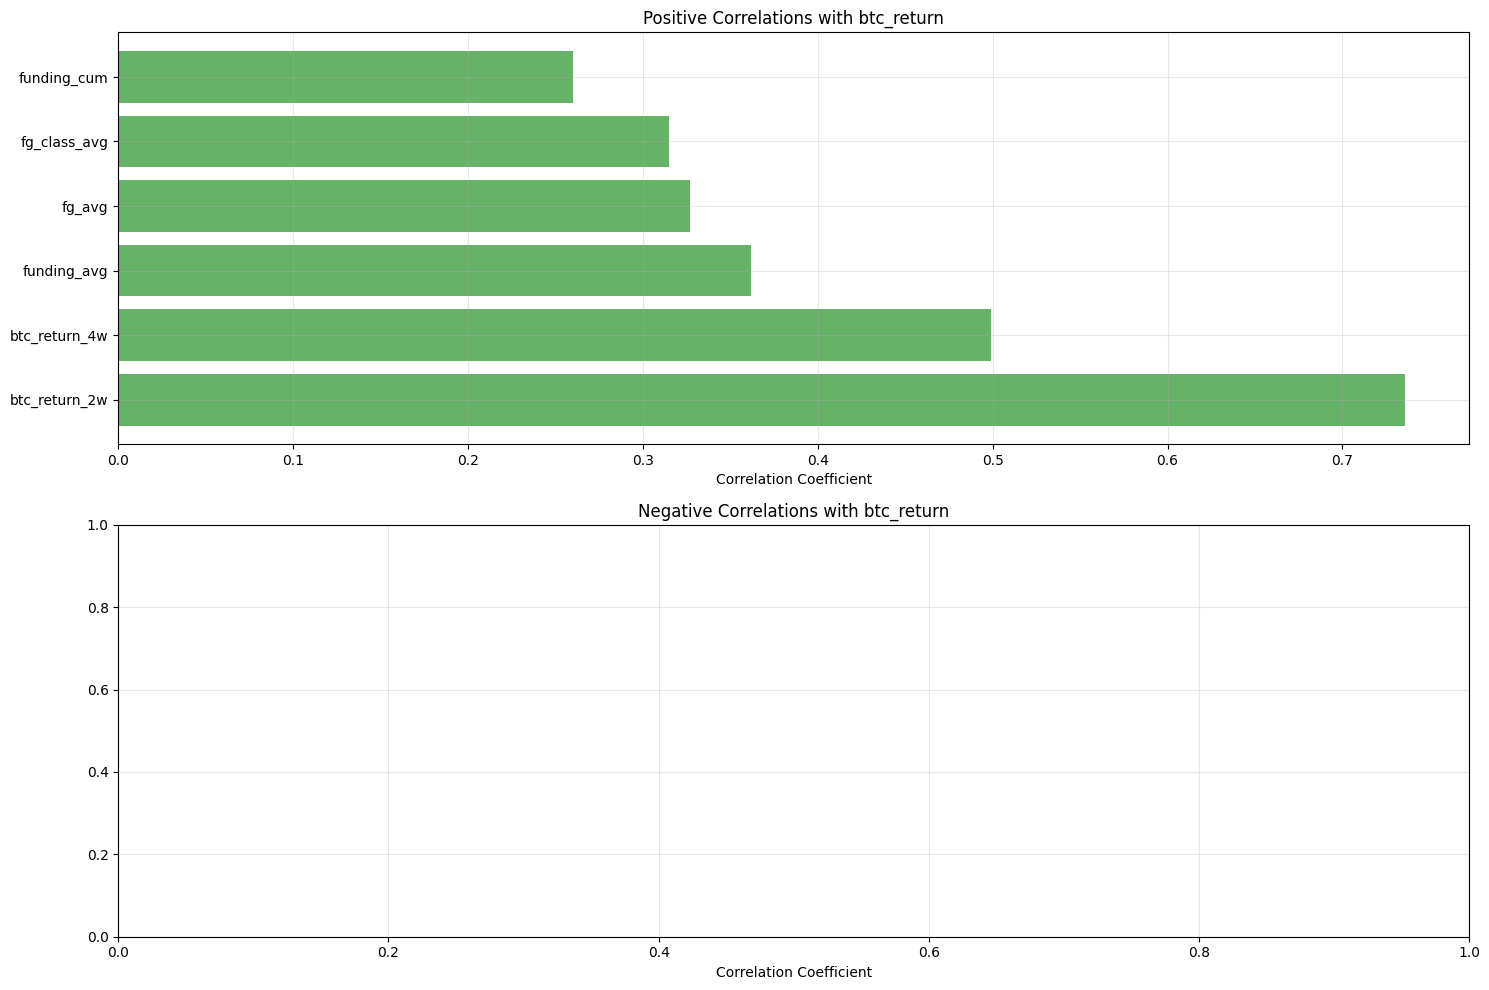


Top correlations with btc_return:

Positive correlations:
btc_return_2w: 0.736
btc_return_4w: 0.499
funding_avg: 0.362
fg_avg: 0.327
fg_class_avg: 0.315

Negative correlations:




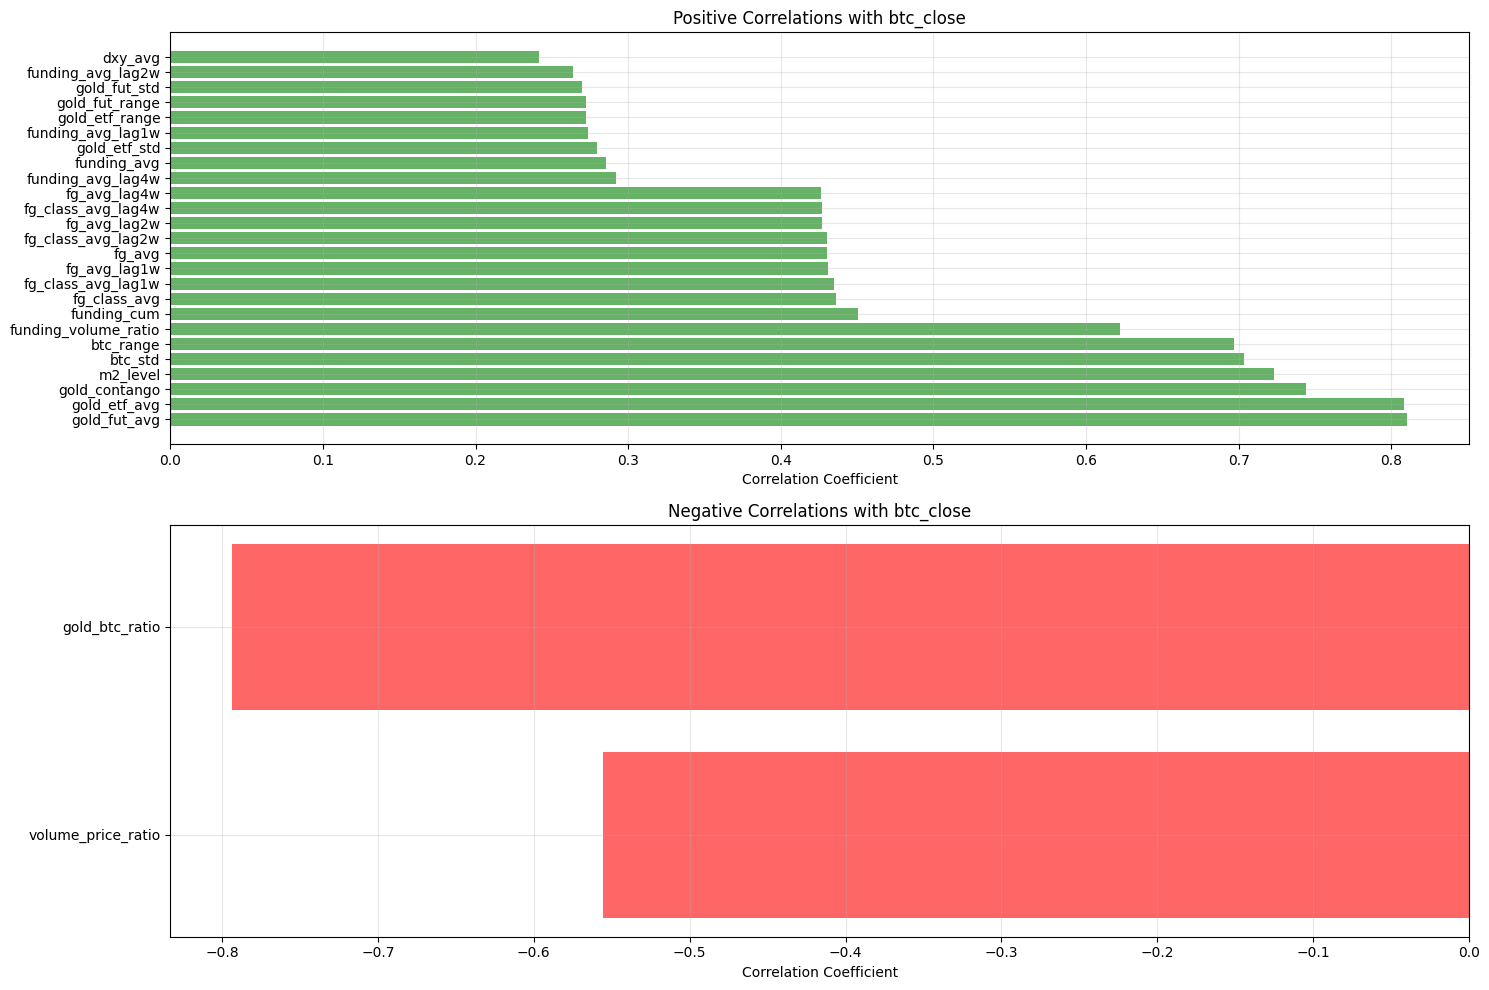


Top correlations with btc_close:

Positive correlations:
gold_fut_avg: 0.810
gold_etf_avg: 0.808
gold_contango: 0.744
m2_level: 0.723
btc_std: 0.704

Negative correlations:
volume_price_ratio: -0.556
gold_btc_ratio: -0.794




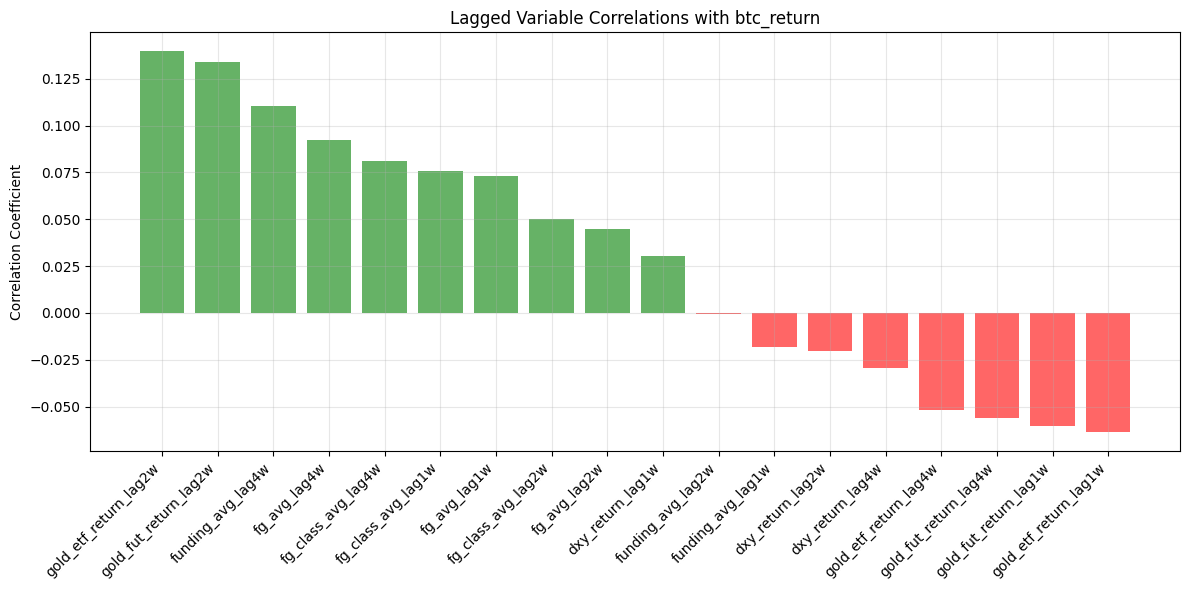

In [20]:
# Plot correlations for both BTC return and price
plot_btc_correlations(weekly_metrics, 
                     target_cols=['btc_return', 'btc_close'],
                     min_correlation=0.2)

# Analyze lagged correlations specifically
lag_correlations = analyze_lagged_correlations(weekly_metrics, 
                                             target='btc_return')

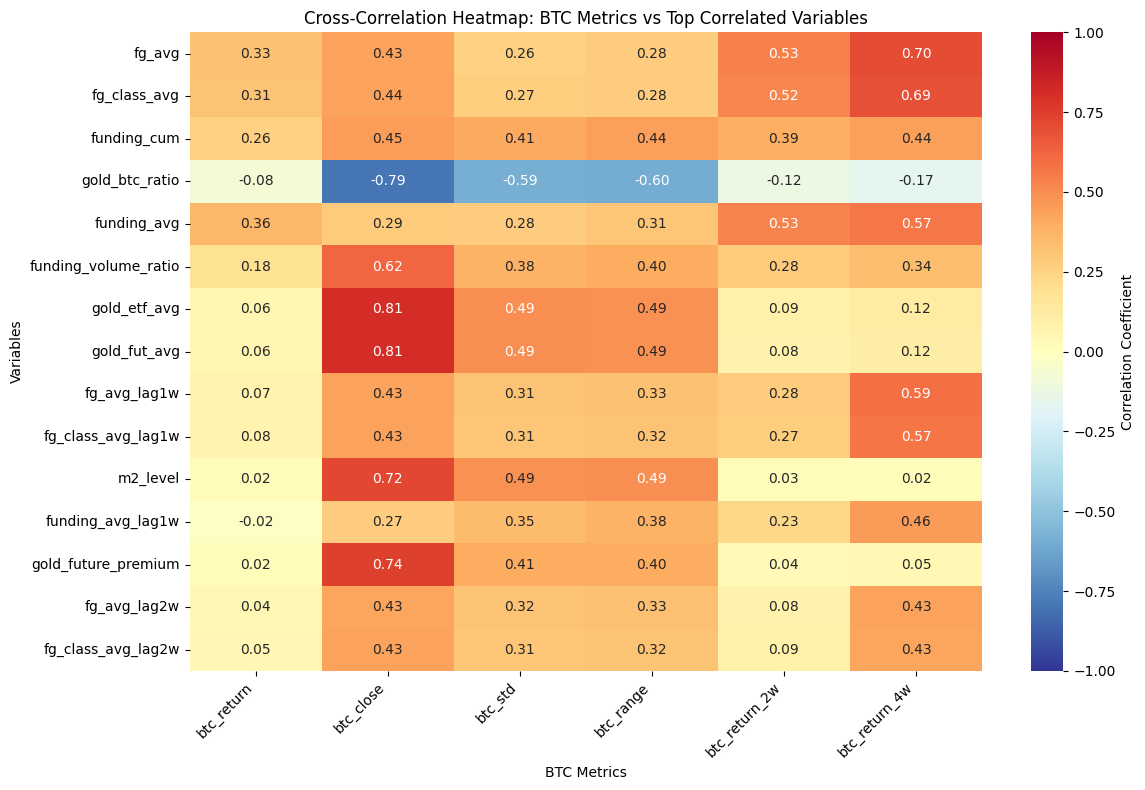


=== Detailed Correlation Breakdown ===


Top 5 correlations for btc_return:
--------------------------------------------------
funding_avg                       0.362 (positive)
    → Funding rate relationship
fg_avg                            0.327 (positive)
    → Fear & Greed indicator relationship
fg_class_avg                      0.315 (positive)
    → Fear & Greed indicator relationship
funding_cum                       0.260 (positive)
    → Funding rate relationship
funding_volume_ratio              0.184 (positive)
    → Trading volume relationship


Top 5 correlations for btc_close:
--------------------------------------------------
gold_fut_avg                      0.810 (positive)
gold_etf_avg                      0.808 (positive)
gold_future_premium               0.744 (positive)
m2_level                          0.723 (positive)
funding_volume_ratio              0.622 (positive)
    → Trading volume relationship


Top 5 correlations for btc_std:
-------------------------

In [30]:
# Define BTC metrics you want to analyze
btc_metrics = ['btc_return', 'btc_close', 'btc_std', 'btc_range', 'btc_return_2w', 'btc_return_4w']

# Create the heatmap
plot_btc_correlation_heatmap(weekly_metrics, 
                            btc_metrics=btc_metrics,
                            min_correlation=0.2)

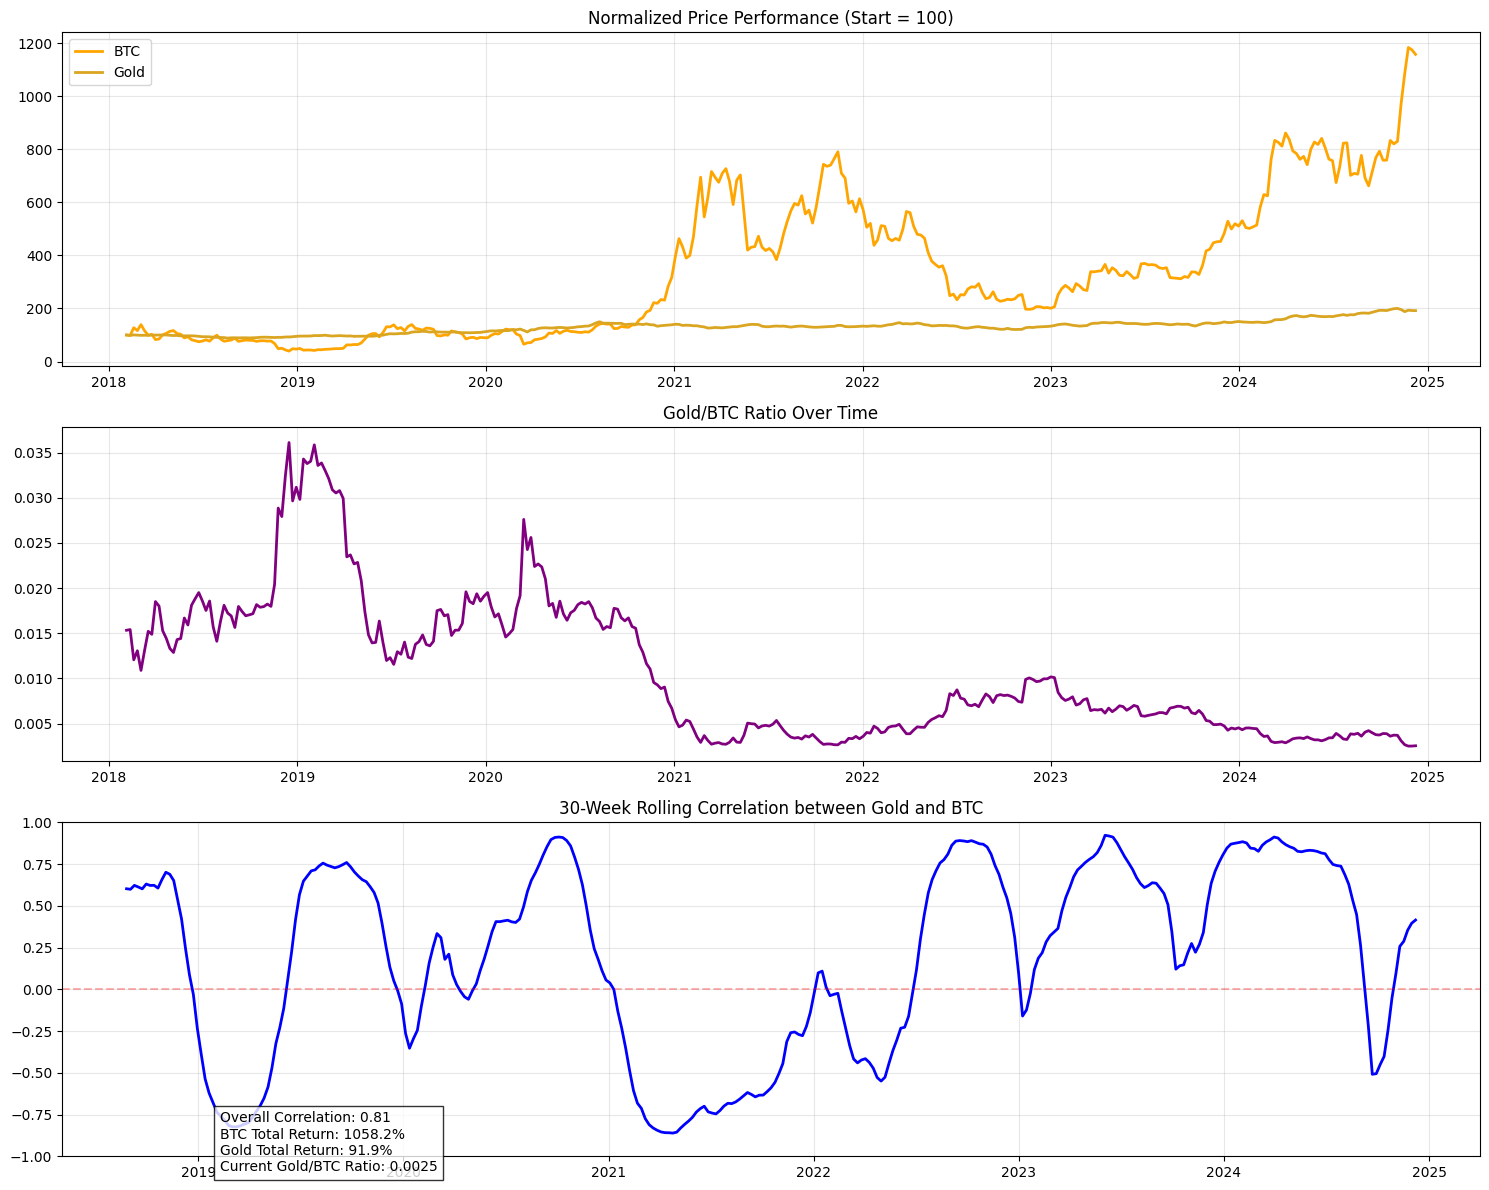


Key Statistics:
Highest Gold/BTC Ratio: 0.0361
Lowest Gold/BTC Ratio: 0.0025
Average Gold/BTC Ratio: 0.0107
Gold/BTC Ratio Volatility: 0.0078

Strong Relationship Periods:
Strongest inverse correlation: -0.861 at 2021-04-25
Strongest positive correlation: 0.922 at 2023-06-04


In [32]:
plot_gold_btc_comparison(weekly_metrics)

Analysis of the key relationships identified in the correlation data:

Weekly Returns (btc_return):
- Shows moderate positive correlation with funding rates and Fear & Greed metrics, suggesting immediate market sentiment and derivatives activity align with short-term price movements
- Relatively weak correlations overall (all under 0.4) indicating weekly returns are somewhat unpredictable

Price Level (btc_close):
- Strong correlation (>0.8) with gold prices, suggesting BTC may be acting similarly to traditional store-of-value assets
- Strong positive relationship with M2 money supply, potentially indicating BTC responds to monetary expansion
- Meaningful correlation with funding/volume metrics, showing market activity tracks with price levels

Volatility Measures (btc_std and btc_range):
- Moderate correlations (0.4-0.5) with gold prices and M2 levels
- Price volatility shows consistent relationship with funding rates, suggesting derivatives market activity may influence price swings

2-Week Returns (btc_return_2w):
- Stronger correlations with sentiment metrics compared to weekly returns
- Fear & Greed and funding rates show >0.5 correlation, indicating medium-term price movements align more closely with market sentiment

4-Week Returns (btc_return_4w):
- Very strong correlation (>0.7) with Fear & Greed metrics
- Shows memory effect with lagged F&G values still maintaining >0.5 correlation
- Suggests market sentiment and longer-term price trends are highly interlinked

Overall Patterns:
- Longer timeframe returns show stronger correlations than short-term
- Fear & Greed index is particularly important for multi-week trends
- Gold prices track closely with BTC price levels but less so with returns
- Funding rates consistently correlate across all metrics, indicating derivatives market importance
- M2 money supply relates more to price levels than to returns

In [33]:
def plot_macro_btc_comparison(weekly_metrics, figsize=(15, 20)):
    """
    Create multiple plots comparing macro metrics (Gold, M2, DXY) and bitcoin over time.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing weekly metrics with datetime index
    figsize : tuple
        Size of the figure
    """
    fig, axs = plt.subplots(5, 1, figsize=figsize)
    
    # Plot 1: Normalized prices for all assets
    ax = axs[0]
    # Normalize each series to start at 100
    btc_normalized = weekly_metrics['btc_close'] / weekly_metrics['btc_close'].iloc[0] * 100
    gold_normalized = weekly_metrics['gold_etf_avg'] / weekly_metrics['gold_etf_avg'].iloc[0] * 100
    m2_normalized = weekly_metrics['m2_level'] / weekly_metrics['m2_level'].iloc[0] * 100
    dxy_normalized = weekly_metrics['dxy_avg'] / weekly_metrics['dxy_avg'].iloc[0] * 100
    
    ax.plot(weekly_metrics.index, btc_normalized, label='BTC', color='orange', linewidth=2)
    ax.plot(weekly_metrics.index, gold_normalized, label='Gold', color='goldenrod', linewidth=2)
    ax.plot(weekly_metrics.index, m2_normalized, label='M2 Supply', color='green', linewidth=2)
    ax.plot(weekly_metrics.index, dxy_normalized, label='DXY', color='blue', linewidth=2)
    ax.set_title('Normalized Performance (Start = 100)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Asset/BTC Ratios
    ax = axs[1]
    # Normalize ratios to start at 1 for better comparison
    gold_ratio = weekly_metrics['gold_btc_ratio'] / weekly_metrics['gold_btc_ratio'].iloc[0]
    m2_btc_ratio = (weekly_metrics['m2_level'] / weekly_metrics['btc_close']) / (weekly_metrics['m2_level'].iloc[0] / weekly_metrics['btc_close'].iloc[0])
    dxy_btc_ratio = (weekly_metrics['dxy_avg'] / weekly_metrics['btc_close']) / (weekly_metrics['dxy_avg'].iloc[0] / weekly_metrics['btc_close'].iloc[0])
    
    ax.plot(weekly_metrics.index, gold_ratio, label='Gold/BTC', color='goldenrod', linewidth=2)
    ax.plot(weekly_metrics.index, m2_btc_ratio, label='M2/BTC', color='green', linewidth=2)
    ax.plot(weekly_metrics.index, dxy_btc_ratio, label='DXY/BTC', color='blue', linewidth=2)
    ax.set_title('Normalized Asset/BTC Ratios Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: 30-week Rolling Correlations
    ax = axs[2]
    roll_corr_gold = weekly_metrics['btc_close'].rolling(window=30).corr(weekly_metrics['gold_etf_avg'])
    roll_corr_m2 = weekly_metrics['btc_close'].rolling(window=30).corr(weekly_metrics['m2_level'])
    roll_corr_dxy = weekly_metrics['btc_close'].rolling(window=30).corr(weekly_metrics['dxy_avg'])
    
    ax.plot(weekly_metrics.index, roll_corr_gold, label='BTC-Gold', color='goldenrod', linewidth=2)
    ax.plot(weekly_metrics.index, roll_corr_m2, label='BTC-M2', color='green', linewidth=2)
    ax.plot(weekly_metrics.index, roll_corr_dxy, label='BTC-DXY', color='blue', linewidth=2)
    ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
    ax.set_title('30-Week Rolling Correlations with BTC')
    ax.set_ylim(-1, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Monthly Changes
    ax = axs[3]
    ax.plot(weekly_metrics.index, weekly_metrics['btc_return'], label='BTC', color='orange', alpha=0.5)
    ax.plot(weekly_metrics.index, weekly_metrics['m2_mom'], label='M2', color='green', alpha=0.5)
    ax.plot(weekly_metrics.index, weekly_metrics['dxy_return'], label='DXY', color='blue', alpha=0.5)
    ax.set_title('Weekly Returns Comparison')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 5: Volatility Comparison (rolling 30-week std)
    ax = axs[4]
    btc_vol = weekly_metrics['btc_return'].rolling(window=30).std()
    gold_vol = (weekly_metrics['gold_etf_avg'].pct_change().rolling(window=30).std())
    dxy_vol = weekly_metrics['dxy_return'].rolling(window=30).std()
    
    ax.plot(weekly_metrics.index, btc_vol, label='BTC', color='orange', linewidth=2)
    ax.plot(weekly_metrics.index, gold_vol, label='Gold', color='goldenrod', linewidth=2)
    ax.plot(weekly_metrics.index, dxy_vol, label='DXY', color='blue', linewidth=2)
    ax.set_title('30-Week Rolling Volatility')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Add overall correlation stats in text box
    stats_text = (
        f"Overall Correlations with BTC:\n"
        f"Gold: {weekly_metrics['btc_close'].corr(weekly_metrics['gold_etf_avg']):.2f}\n"
        f"M2: {weekly_metrics['btc_close'].corr(weekly_metrics['m2_level']):.2f}\n"
        f"DXY: {weekly_metrics['btc_close'].corr(weekly_metrics['dxy_avg']):.2f}\n"
        f"\nTotal Returns:\n"
        f"BTC: {(btc_normalized.iloc[-1]-100):.1f}%\n"
        f"Gold: {(gold_normalized.iloc[-1]-100):.1f}%\n"
        f"M2: {(m2_normalized.iloc[-1]-100):.1f}%\n"
        f"DXY: {(dxy_normalized.iloc[-1]-100):.1f}%"
    )
    
    fig.text(0.15, 0.02, stats_text, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

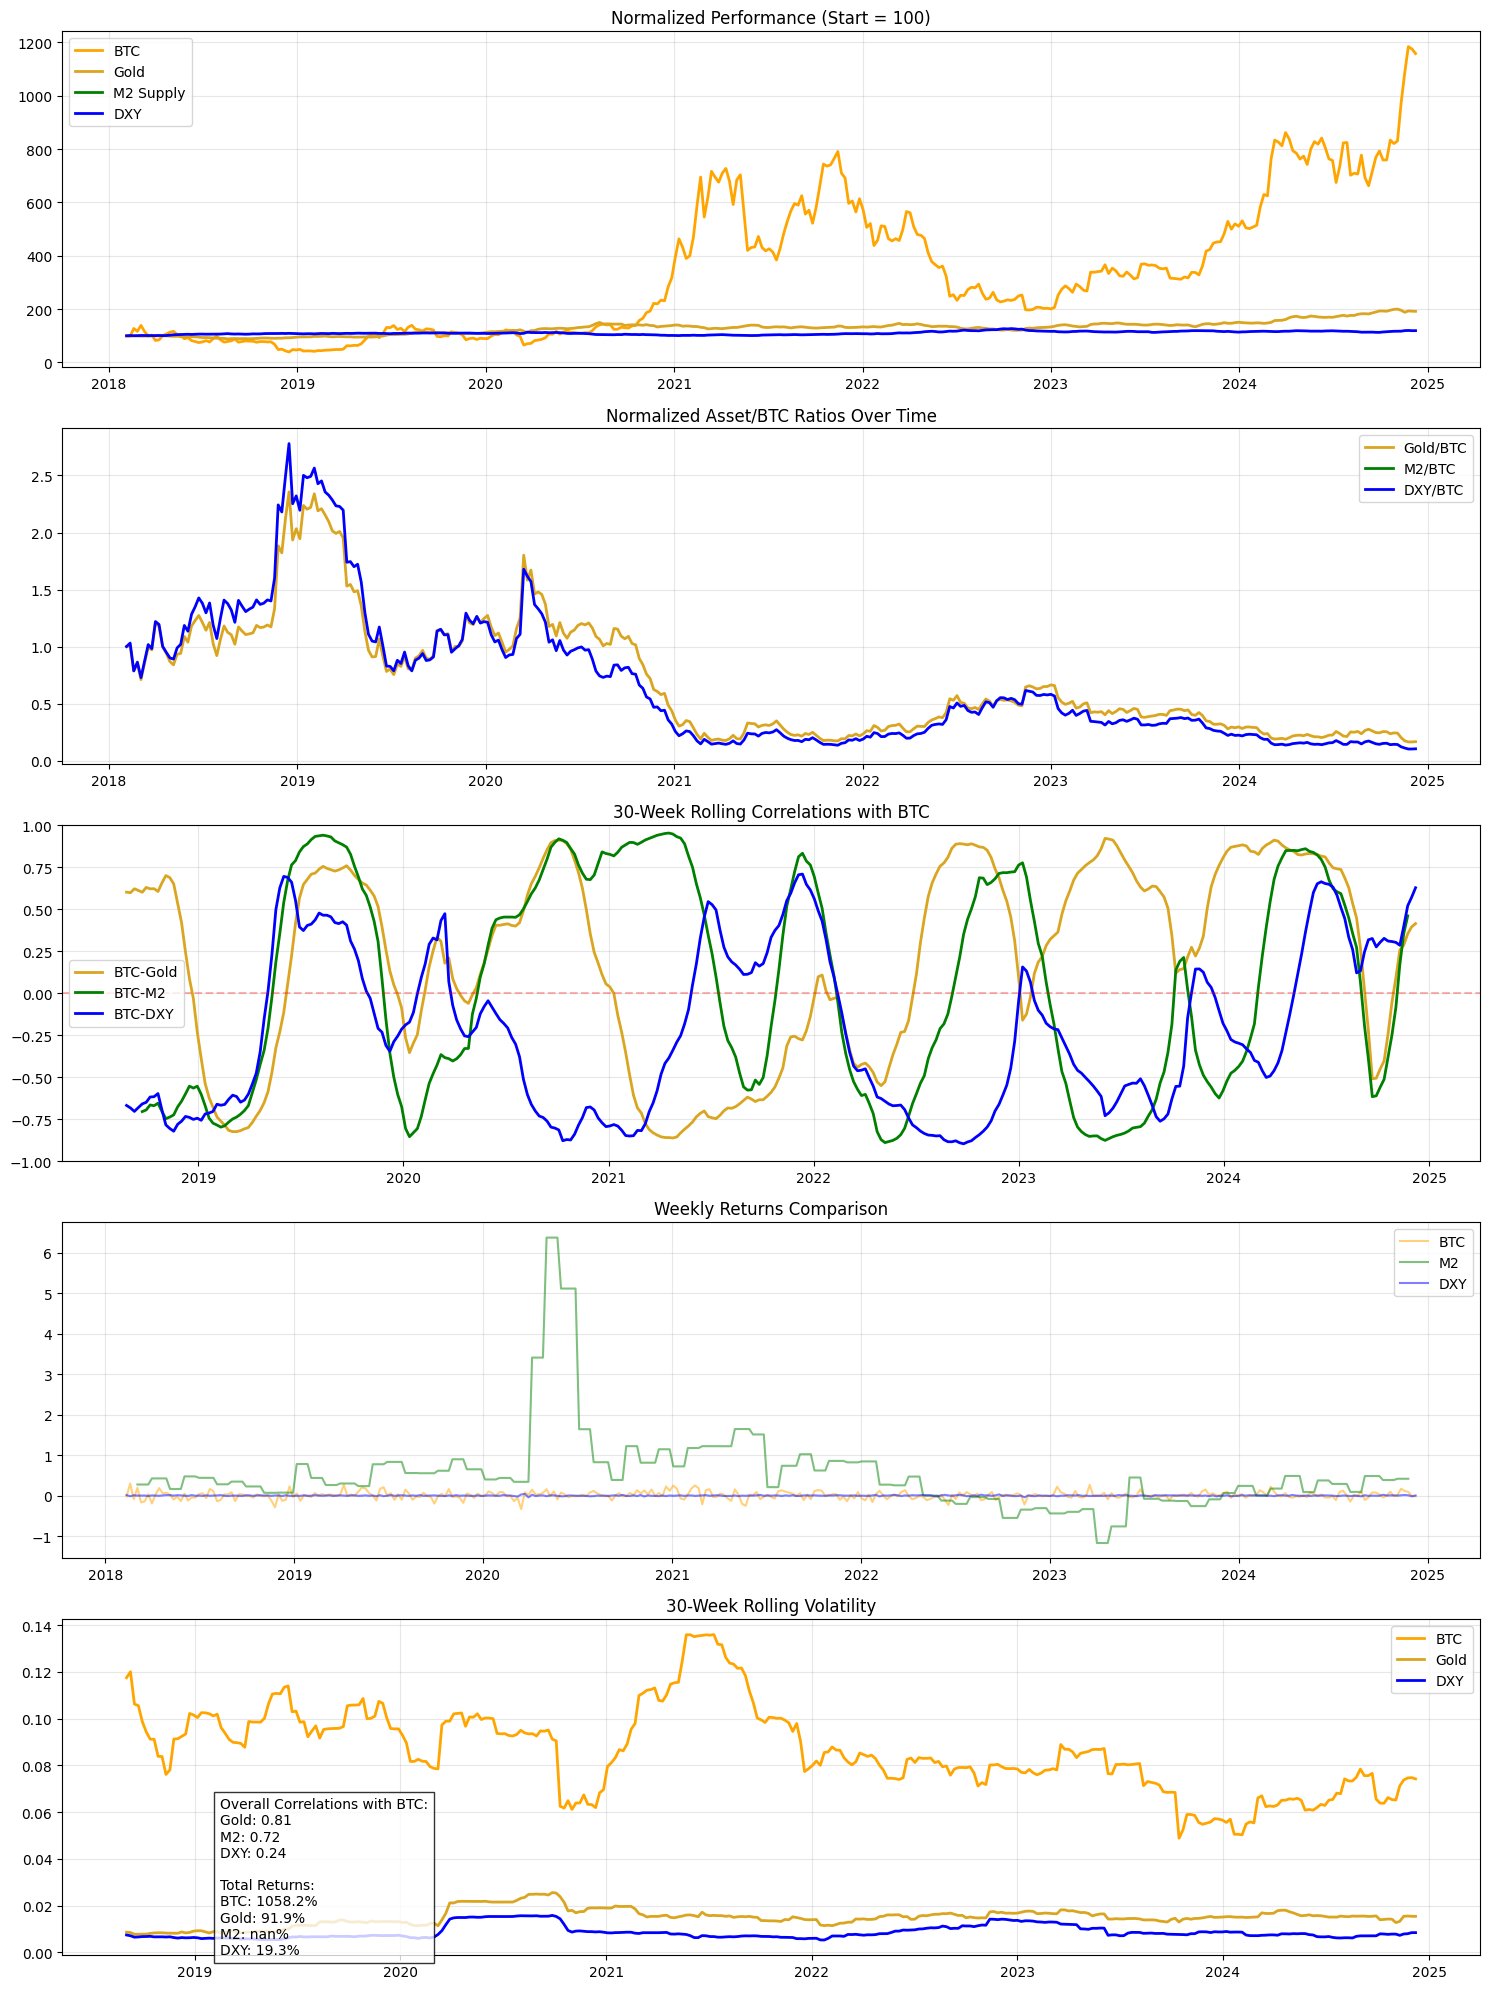

In [34]:
plot_macro_btc_comparison(weekly_metrics)

In [45]:
from scipy import stats

def plot_yearly_asset_return_correlations(weekly_metrics, figsize=(15, 10)):
    """
    Create scatter plots showing relationships between BTC, Gold, and DXY returns for each year.
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing weekly metrics with datetime index
    figsize : tuple
        Base size of the figure, will be adjusted based on number of years
    """
    # Calculate log returns
    btc_ret = np.log(weekly_metrics['btc_close']).diff()
    gold_ret = np.log(weekly_metrics['gold_etf_avg']).diff()
    dxy_ret = np.log(weekly_metrics['dxy_avg']).diff()
    
    # Get unique years in the data
    years = weekly_metrics.index.year.unique()
    n_years = len(years)
    
    # Create a figure with subplots for each year
    # 3 plots per row (one for each pair of assets)
    n_rows = n_years
    n_cols = 3
    
    # Adjust figure size based on number of years
    fig_height = figsize[1] * (n_years / 2)  # Increase height based on number of years
    fig = plt.figure(figsize=(figsize[0], fig_height))
    
    # Define pairs for plotting
    pairs = [
        (btc_ret, gold_ret, 'BTC vs Gold Returns', 'gold'),
        (btc_ret, dxy_ret, 'BTC vs DXY Returns', 'blue'),
        (gold_ret, dxy_ret, 'Gold vs DXY Returns', 'green')
    ]
    
    for year_idx, year in enumerate(years):
        # Create mask for current year
        year_mask = weekly_metrics.index.year == year
        
        for pair_idx, (x, y, title, color) in enumerate(pairs):
            # Calculate subplot position
            plot_idx = year_idx * 3 + pair_idx + 1
            ax = plt.subplot(n_rows, n_cols, plot_idx)
            
            # Get data for current year
            x_year = x[year_mask]
            y_year = y[year_mask]
            
            # Create scatter plot
            ax.scatter(x_year, y_year, alpha=0.5, color=color, s=30)
            
            # Add regression line if we have enough data points
            if len(x_year.dropna()) > 2:  # Need at least 3 points for regression
                slope, intercept, r_value, p_value, _ = stats.linregress(x_year.dropna(), y_year.dropna())
                line_x = np.array([x_year.min(), x_year.max()])
                line_y = slope * line_x + intercept
                ax.plot(line_x, line_y, color='red', linestyle='--', alpha=0.8)
                
                # Add R² and correlation text
                corr = x_year.corr(y_year)
                ax.text(0.05, 0.95, 
                        f'R² = {r_value**2:.3f}\nCorr = {corr:.3f}', 
                        transform=ax.transAxes,
                        bbox=dict(facecolor='white', alpha=0.8))
            
            # Add zero lines
            ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
            ax.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
            
            # Add grid
            ax.grid(True, alpha=0.2)
            
            # Set title (only for first row)
            if year_idx == 0:
                ax.set_title(f'{title}')
            
            # Add year label
            ax.text(0.98, 0.02, str(year), transform=ax.transAxes, 
                   ha='right', va='bottom', fontsize=12, 
                   bbox=dict(facecolor='white', alpha=0.8))
            
            # Label axes (only for edge plots)
            if pair_idx == 0:  # First column
                ax.set_ylabel(f'Weekly Log Return')
            if year_idx == n_years - 1:  # Last row
                ax.set_xlabel(f'Weekly Log Return')
                
            # Calculate and display quadrant percentages
            mask = ~(x_year.isna() | y_year.isna())
            q1 = np.mean((x_year > 0) & (y_year > 0) & mask) * 100  # upper right
            q2 = np.mean((x_year < 0) & (y_year > 0) & mask) * 100  # upper left
            q3 = np.mean((x_year < 0) & (y_year < 0) & mask) * 100  # lower left
            q4 = np.mean((x_year > 0) & (y_year < 0) & mask) * 100  # lower right
            
            # Add small quadrant percentages
            fontsize = 8
            ax.text(0.98, 0.98, f'{q1:.1f}%', transform=ax.transAxes, ha='right', va='top', fontsize=fontsize)
            ax.text(0.02, 0.98, f'{q2:.1f}%', transform=ax.transAxes, ha='left', va='top', fontsize=fontsize)
            ax.text(0.02, 0.02, f'{q3:.1f}%', transform=ax.transAxes, ha='left', va='bottom', fontsize=fontsize)
            ax.text(0.98, 0.85, f'{q4:.1f}%', transform=ax.transAxes, ha='right', va='top', fontsize=fontsize)
    
    plt.tight_layout()
    plt.show()
    
    # Print yearly correlations summary
    print("\nYearly Correlations Summary:")
    print("=" * 50)
    for year in years:
        year_mask = weekly_metrics.index.year == year
        print(f"\nYear {year}:")
        for x, y, title, _ in pairs:
            corr = x[year_mask].corr(y[year_mask])
            print(f"{title}: {corr:.3f}")

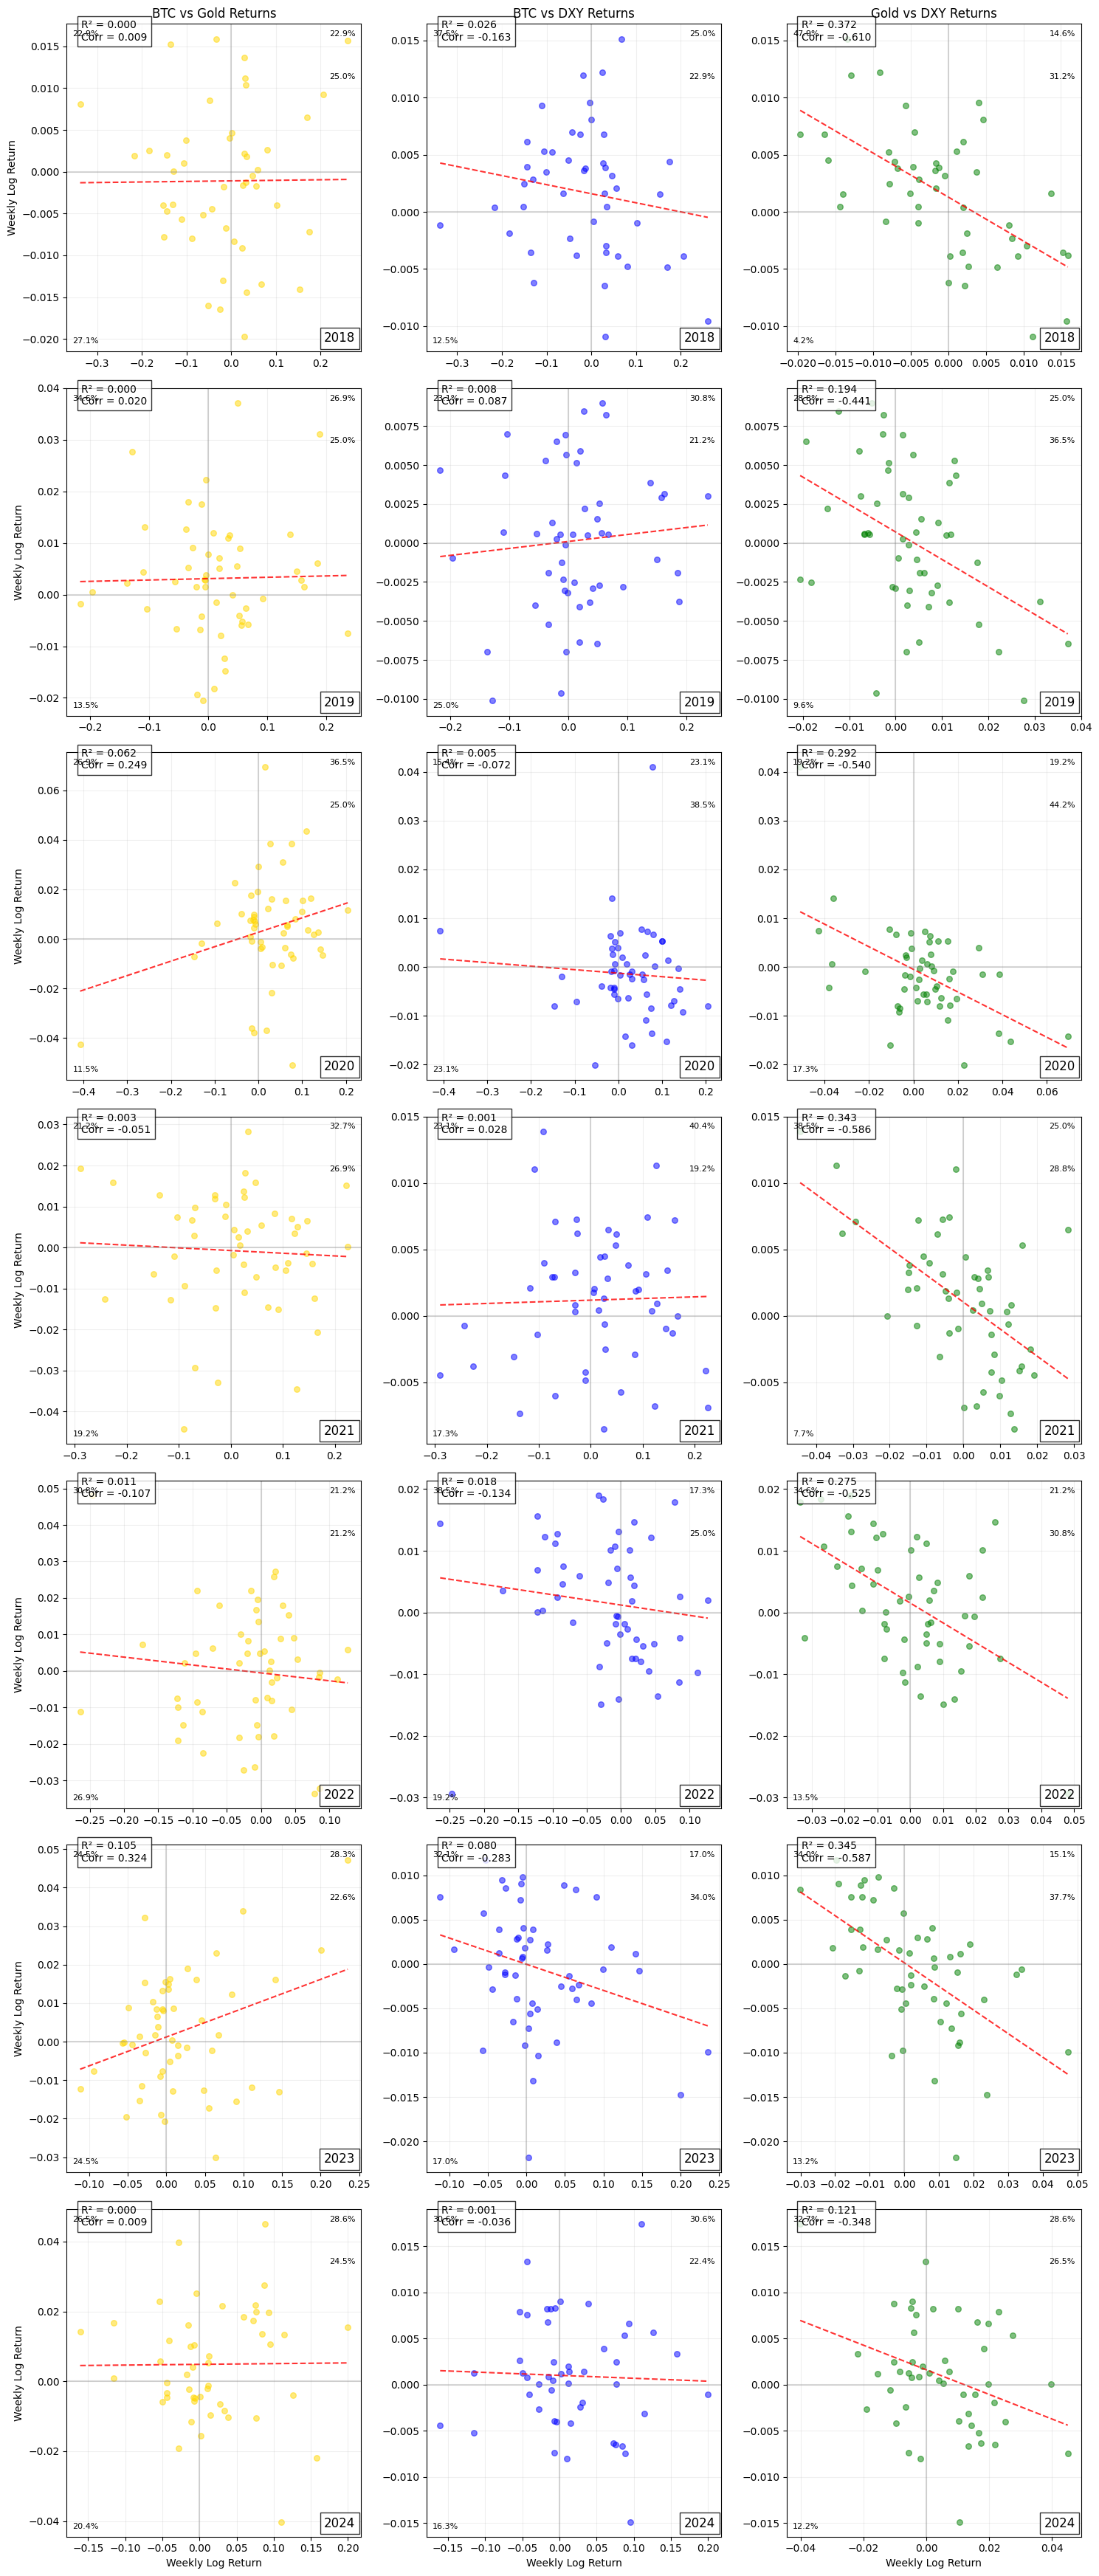


Yearly Correlations Summary:

Year 2018:
BTC vs Gold Returns: 0.009
BTC vs DXY Returns: -0.163
Gold vs DXY Returns: -0.610

Year 2019:
BTC vs Gold Returns: 0.020
BTC vs DXY Returns: 0.087
Gold vs DXY Returns: -0.441

Year 2020:
BTC vs Gold Returns: 0.249
BTC vs DXY Returns: -0.072
Gold vs DXY Returns: -0.540

Year 2021:
BTC vs Gold Returns: -0.051
BTC vs DXY Returns: 0.028
Gold vs DXY Returns: -0.586

Year 2022:
BTC vs Gold Returns: -0.107
BTC vs DXY Returns: -0.134
Gold vs DXY Returns: -0.525

Year 2023:
BTC vs Gold Returns: 0.324
BTC vs DXY Returns: -0.283
Gold vs DXY Returns: -0.587

Year 2024:
BTC vs Gold Returns: 0.009
BTC vs DXY Returns: -0.036
Gold vs DXY Returns: -0.348


In [47]:
plot_yearly_asset_return_correlations(weekly_metrics)

In [50]:
def analyze_btc_gold_relationship(weekly_metrics, correlation_window=12):
    """
    Analyze and visualize the evolving relationship between BTC and Gold
    
    Parameters:
    -----------
    weekly_metrics : pd.DataFrame
        DataFrame containing weekly metrics
    correlation_window : int
        Window size in weeks for rolling correlation
    """
    # Calculate returns
    btc_ret = np.log(weekly_metrics['btc_close']).diff()
    gold_ret = np.log(weekly_metrics['gold_etf_avg']).diff()
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 15))
    
    # 1. Price Evolution (Normalized)
    btc_norm = weekly_metrics['btc_close'] / weekly_metrics['btc_close'].iloc[0] * 100
    gold_norm = weekly_metrics['gold_etf_avg'] / weekly_metrics['gold_etf_avg'].iloc[0] * 100
    
    ax1.plot(weekly_metrics.index, btc_norm, label='BTC', color='orange', linewidth=2)
    ax1.plot(weekly_metrics.index, gold_norm, label='Gold', color='gold', linewidth=2)
    ax1.set_title('Normalized Price Evolution (Start = 100)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Rolling Correlation
    rolling_corr = btc_ret.rolling(window=correlation_window).corr(gold_ret)
    
    # Calculate yearly correlations for horizontal lines
    yearly_corrs = {}
    for year in weekly_metrics.index.year.unique():
        mask = weekly_metrics.index.year == year
        yearly_corrs[year] = btc_ret[mask].corr(gold_ret[mask])
    
    # Plot rolling correlation
    ax2.plot(weekly_metrics.index, rolling_corr, color='blue', linewidth=2)
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.3)
    
    # Add yearly correlation lines
    for year, corr in yearly_corrs.items():
        year_data = weekly_metrics[weekly_metrics.index.year == year]
        ax2.hlines(y=corr, 
                  xmin=year_data.index[0], 
                  xmax=year_data.index[-1], 
                  colors='green', 
                  linestyles=':', 
                  alpha=0.5)
        ax2.text(year_data.index[0], corr, f'{year}: {corr:.3f}', 
                verticalalignment='bottom')
    
    ax2.set_title(f'{correlation_window}-Week Rolling Correlation between BTC and Gold')
    ax2.grid(True, alpha=0.3)
    
    # 3. Joint Return Distribution with Quadrant Analysis
    yearly_colors = plt.cm.viridis(np.linspace(0, 1, len(weekly_metrics.index.year.unique())))
    
    for year, color in zip(weekly_metrics.index.year.unique(), yearly_colors):
        year_mask = weekly_metrics.index.year == year
        btc_year = btc_ret[year_mask]
        gold_year = gold_ret[year_mask]
        
        # Scatter plot for this year
        ax3.scatter(btc_year, gold_year, alpha=0.5, color=color, label=str(year))
    
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax3.set_xlabel('BTC Log Return')
    ax3.set_ylabel('Gold Log Return')
    ax3.set_title('Return Distribution by Year with Quadrant Counts')
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # Calculate and display quadrant counts by year
    for year in weekly_metrics.index.year.unique():
        year_mask = weekly_metrics.index.year == year
        btc_year = btc_ret[year_mask]
        gold_year = gold_ret[year_mask]
        
        # Remove NaN values
        valid_mask = ~(btc_year.isna() | gold_year.isna())
        btc_year = btc_year[valid_mask]
        gold_year = gold_year[valid_mask]
        
        # Count points in each quadrant
        q1 = np.sum((btc_year > 0) & (gold_year > 0))  # top right
        q2 = np.sum((btc_year < 0) & (gold_year > 0))  # top left
        q3 = np.sum((btc_year < 0) & (gold_year < 0))  # bottom left
        q4 = np.sum((btc_year > 0) & (gold_year < 0))  # bottom right
        
        # Calculate percentages
        total = len(btc_year)
        q1_pct = q1/total * 100
        q2_pct = q2/total * 100
        q3_pct = q3/total * 100
        q4_pct = q4/total * 100
        
        # Add counts to plot in each quadrant with year
        # Position text based on axis limits
        x_max = ax3.get_xlim()[1]
        x_min = ax3.get_xlim()[0]
        y_max = ax3.get_ylim()[1]
        y_min = ax3.get_ylim()[0]
        
        # Calculate positions (adjust these multipliers to fine-tune positioning)
        x_pos_right = x_max * 0.7
        x_pos_left = x_min * 0.7
        y_pos_top = y_max * 0.7
        y_pos_bottom = y_min * 0.7
        
        # Add text with counts and percentages
        text_template = f'{year}: {{}}\n({{:.1f}}%)'
        ax3.text(x_pos_right, y_pos_top, text_template.format(q1, q1_pct), color=color)  # Q1
        ax3.text(x_pos_left, y_pos_top, text_template.format(q2, q2_pct), color=color)   # Q2
        ax3.text(x_pos_left, y_pos_bottom, text_template.format(q3, q3_pct), color=color) # Q3
        ax3.text(x_pos_right, y_pos_bottom, text_template.format(q4, q4_pct), color=color) # Q4
    
    # Add quadrant labels
    ax3.text(x_max * 0.98, y_max * 0.98, 'Q1: Both Up', ha='right', va='top')
    ax3.text(x_min * 0.98, y_max * 0.98, 'Q2: Gold Up, BTC Down', ha='left', va='top')
    ax3.text(x_min * 0.98, y_min * 0.98, 'Q3: Both Down', ha='left', va='bottom')
    ax3.text(x_max * 0.98, y_min * 0.98, 'Q4: BTC Up, Gold Down', ha='right', va='bottom')

    plt.tight_layout()
    plt.show()

    # Print additional insights
    print("\nQuadrant Analysis by Year:")
    print("=" * 50)
    
    for year in weekly_metrics.index.year.unique():
        year_mask = weekly_metrics.index.year == year
        btc_year = btc_ret[year_mask]
        gold_year = gold_ret[year_mask]
        
        # Remove NaN values
        valid_mask = ~(btc_year.isna() | gold_year.isna())
        btc_year = btc_year[valid_mask]
        gold_year = gold_year[valid_mask]
        
        print(f"\nYear {year}:")
        print(f"Both Up: {np.sum((btc_year > 0) & (gold_year > 0))} weeks")
        print(f"Both Down: {np.sum((btc_year < 0) & (gold_year < 0))} weeks")
        print(f"BTC Up, Gold Down: {np.sum((btc_year > 0) & (gold_year < 0))} weeks")
        print(f"Gold Up, BTC Down: {np.sum((btc_year < 0) & (gold_year > 0))} weeks")
        print(f"Total weeks: {len(btc_year)}")

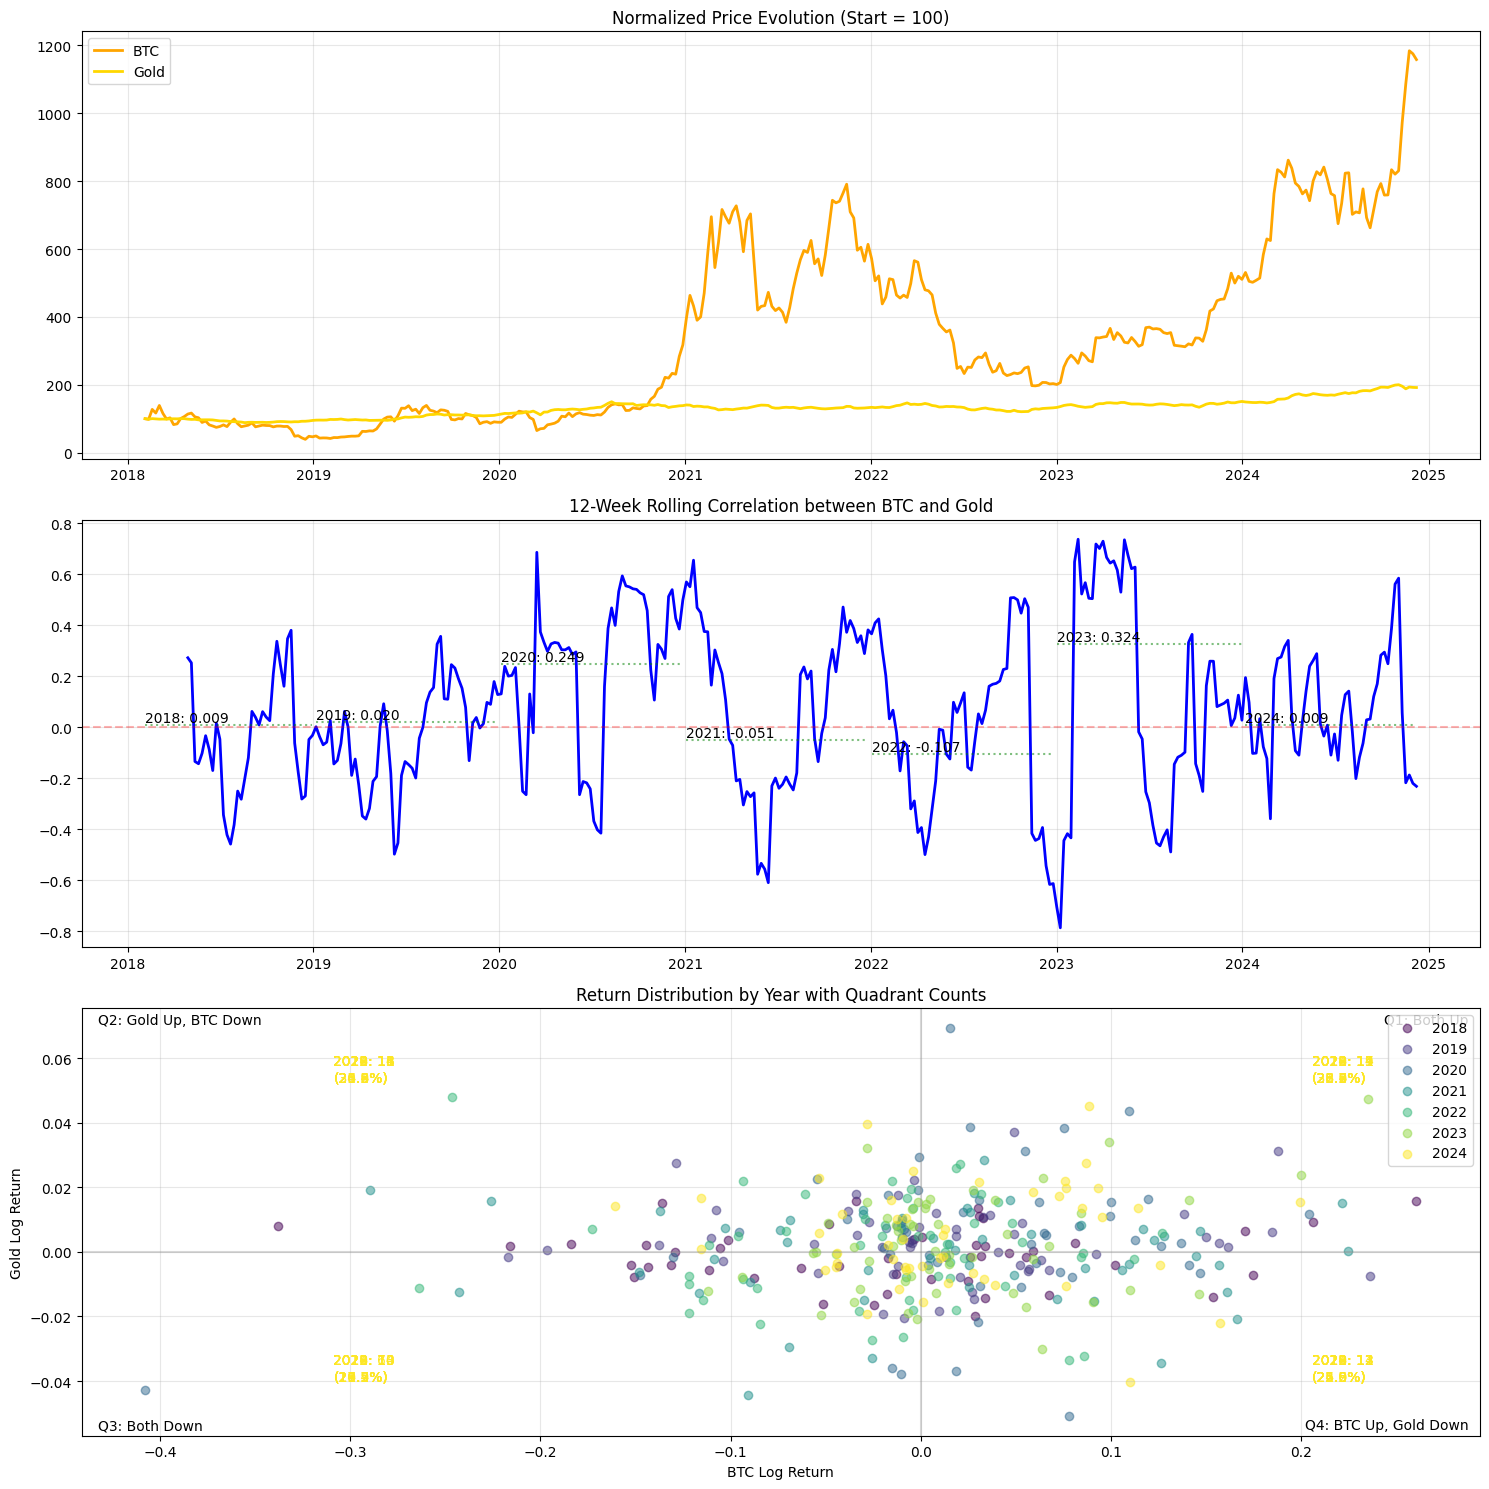


Quadrant Analysis by Year:

Year 2018:
Both Up: 11 weeks
Both Down: 13 weeks
BTC Up, Gold Down: 12 weeks
Gold Up, BTC Down: 11 weeks
Total weeks: 47

Year 2019:
Both Up: 14 weeks
Both Down: 7 weeks
BTC Up, Gold Down: 13 weeks
Gold Up, BTC Down: 18 weeks
Total weeks: 52

Year 2020:
Both Up: 19 weeks
Both Down: 6 weeks
BTC Up, Gold Down: 13 weeks
Gold Up, BTC Down: 14 weeks
Total weeks: 52

Year 2021:
Both Up: 17 weeks
Both Down: 10 weeks
BTC Up, Gold Down: 14 weeks
Gold Up, BTC Down: 11 weeks
Total weeks: 52

Year 2022:
Both Up: 11 weeks
Both Down: 14 weeks
BTC Up, Gold Down: 11 weeks
Gold Up, BTC Down: 16 weeks
Total weeks: 52

Year 2023:
Both Up: 15 weeks
Both Down: 13 weeks
BTC Up, Gold Down: 12 weeks
Gold Up, BTC Down: 13 weeks
Total weeks: 53

Year 2024:
Both Up: 14 weeks
Both Down: 10 weeks
BTC Up, Gold Down: 12 weeks
Gold Up, BTC Down: 13 weeks
Total weeks: 49


In [51]:
analyze_btc_gold_relationship(weekly_metrics)

In [55]:
weekly_metrics.columns

Index(['fg_avg', 'fg_range', 'fg_class_avg', 'fg_extreme_pct', 'fg_avg_lag1w',
       'fg_class_avg_lag1w', 'fg_avg_lag2w', 'fg_class_avg_lag2w',
       'fg_avg_lag4w', 'fg_class_avg_lag4w', 'volume_total', 'volume_avg',
       'volume_std', 'volume_pct_change', 'volume_ma4w', 'funding_avg',
       'funding_range', 'funding_std', 'funding_cum', 'funding_avg_lag1w',
       'funding_avg_lag2w', 'funding_avg_lag4w', 'm2_level', 'm2_mom',
       'm2_3m_change', 'm2_6m_change', 'm2_yoy_change', 'gold_etf_avg',
       'gold_etf_return', 'gold_etf_std', 'gold_etf_range',
       'gold_etf_return_lag1w', 'gold_etf_return_lag2w',
       'gold_etf_return_lag4w', 'gold_fut_avg', 'gold_fut_return',
       'gold_fut_std', 'gold_fut_range', 'gold_fut_return_lag1w',
       'gold_fut_return_lag2w', 'gold_fut_return_lag4w', 'gold_future_premium',
       'dxy_avg', 'dxy_return', 'dxy_std', 'dxy_4w_change', 'dxy_return_lag1w',
       'dxy_return_lag2w', 'dxy_return_lag4w', 'btc_close', 'btc_return',
     

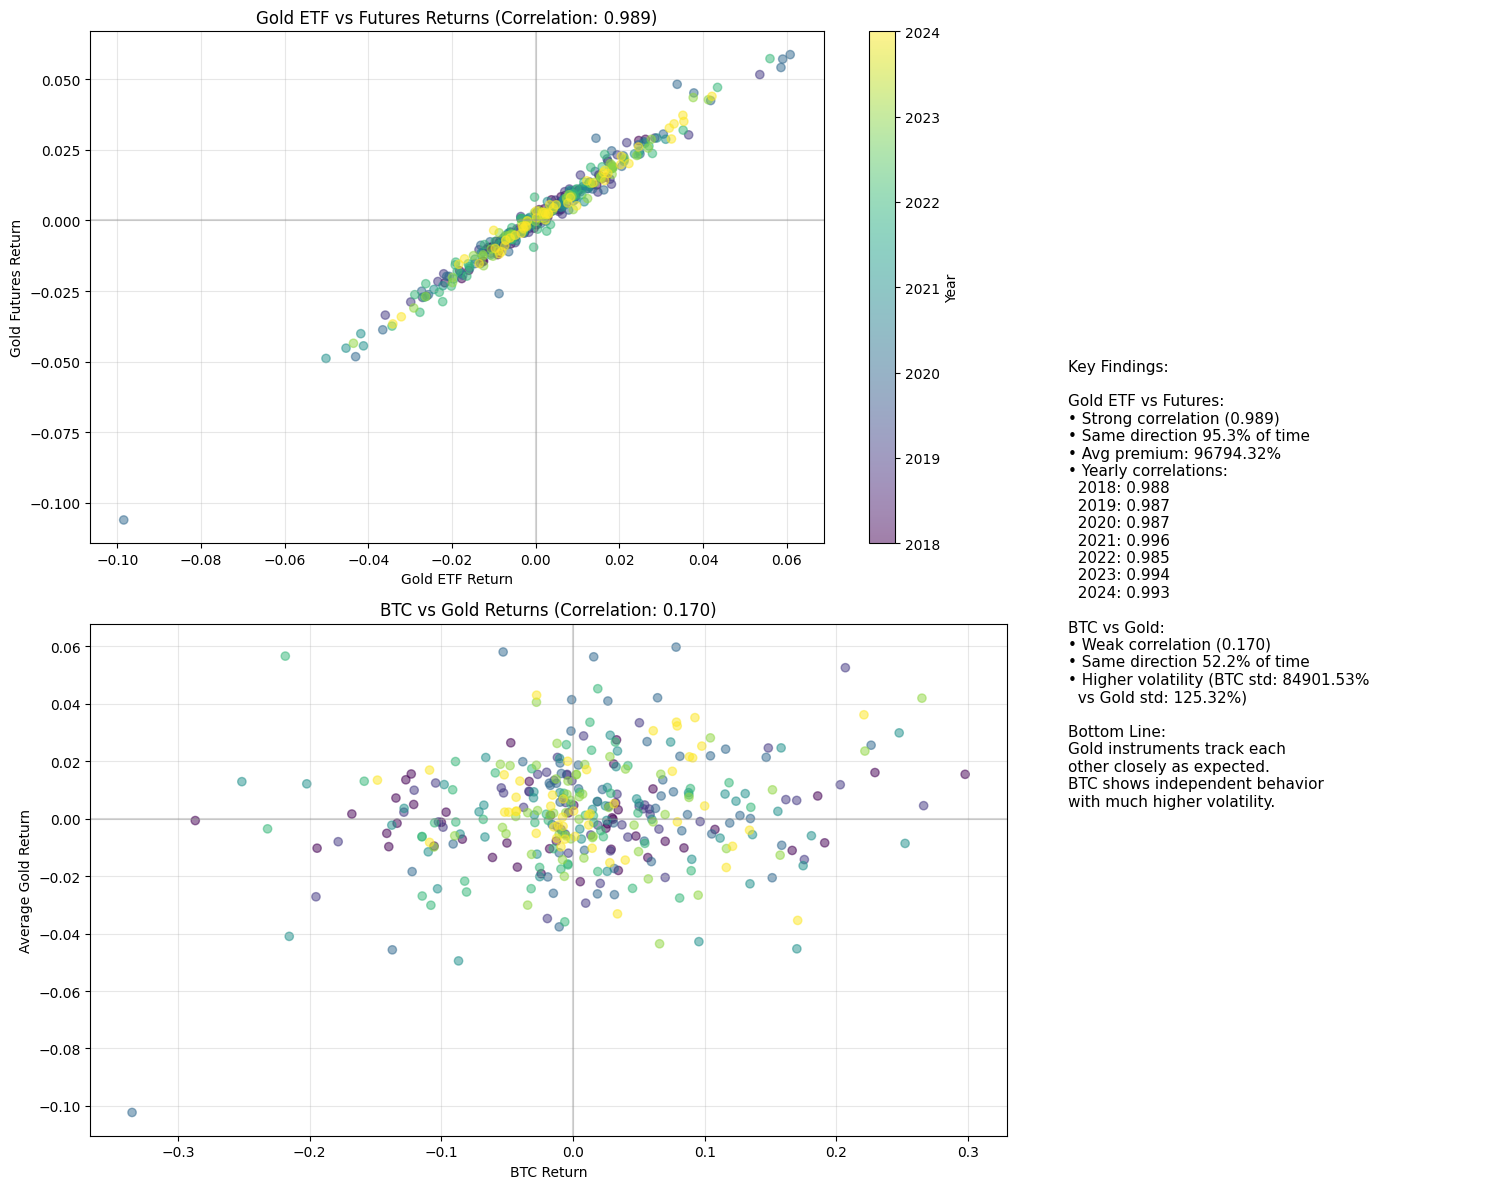


Detailed Premium Statistics:
Average Premium: 96794.3159%
Premium Std Dev: 866.8425%
Max Premium: 98325.0557%
Min Premium: 95155.8256%


In [56]:
def plot_gold_correlations(weekly_metrics, correlation_window=12):
    """Create a comparative analysis of correlations between gold instruments and BTC"""
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])
    
    # 1. Gold ETF vs Futures returns scatter (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    scatter1 = ax1.scatter(weekly_metrics['gold_etf_return'], 
                          weekly_metrics['gold_fut_return'], 
                          alpha=0.5, 
                          c=weekly_metrics.index.year, 
                          cmap='viridis')
    ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax1.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax1.set_xlabel('Gold ETF Return')
    ax1.set_ylabel('Gold Futures Return')
    corr_etf_fut = weekly_metrics['gold_etf_return'].corr(weekly_metrics['gold_fut_return'])
    ax1.set_title(f'Gold ETF vs Futures Returns (Correlation: {corr_etf_fut:.3f})')
    ax1.grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter1, label='Year')
    
    # 2. BTC vs Combined Gold scatter (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    # Average of ETF and Futures returns
    gold_avg_ret = (weekly_metrics['gold_etf_return'] + weekly_metrics['gold_fut_return']) / 2
    scatter2 = ax2.scatter(weekly_metrics['btc_return'], gold_avg_ret, 
                          alpha=0.5,
                          c=weekly_metrics.index.year, 
                          cmap='viridis')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax2.set_xlabel('BTC Return')
    ax2.set_ylabel('Average Gold Return')
    corr_btc_gold = weekly_metrics['btc_return'].corr(gold_avg_ret)
    ax2.set_title(f'BTC vs Gold Returns (Correlation: {corr_btc_gold:.3f})')
    ax2.grid(True, alpha=0.3)
    
    # 3. Text findings (right column)
    ax3 = fig.add_subplot(gs[:, 1])
    ax3.axis('off')
    
    # Calculate key statistics
    etf_fut_same_dir = np.mean(
        ((weekly_metrics['gold_etf_return'] > 0) & (weekly_metrics['gold_fut_return'] > 0)) | 
        ((weekly_metrics['gold_etf_return'] < 0) & (weekly_metrics['gold_fut_return'] < 0))
    ) * 100
    
    btc_gold_same_dir = np.mean(
        ((weekly_metrics['btc_return'] > 0) & (gold_avg_ret > 0)) | 
        ((weekly_metrics['btc_return'] < 0) & (gold_avg_ret < 0))
    ) * 100
    
    # Yearly correlations between ETF and Futures
    yearly_corrs = {}
    for year in weekly_metrics.index.year.unique():
        mask = weekly_metrics.index.year == year
        yearly_corrs[year] = weekly_metrics.loc[mask, 'gold_etf_return'].corr(
            weekly_metrics.loc[mask, 'gold_fut_return'])
    
    # Calculate premium statistics
    premium = weekly_metrics['gold_future_premium']
    
    findings = [
        "Key Findings:",
        "",
        "Gold ETF vs Futures:",
        f"• Strong correlation ({corr_etf_fut:.3f})",
        f"• Same direction {etf_fut_same_dir:.1f}% of time",
        f"• Avg premium: {premium.mean():.2%}",
        "• Yearly correlations:",
        *[f"  {year}: {corr:.3f}" for year, corr in yearly_corrs.items()],
        "",
        "BTC vs Gold:",
        f"• Weak correlation ({corr_btc_gold:.3f})",
        f"• Same direction {btc_gold_same_dir:.1f}% of time",
        f"• Higher volatility (BTC std: {weekly_metrics['btc_std'].mean():.2%}",
        f"  vs Gold std: {weekly_metrics['gold_etf_std'].mean():.2%})",
        "",
        "Bottom Line:",
        "Gold instruments track each",
        "other closely as expected.",
        "BTC shows independent behavior",
        "with much higher volatility."
    ]
    
    ax3.text(0.1, 0.5, '\n'.join(findings), 
             fontsize=11, 
             verticalalignment='center',
             fontfamily='sans-serif')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional statistics
    print("\nDetailed Premium Statistics:")
    print("=" * 50)
    print(f"Average Premium: {premium.mean():.4%}")
    print(f"Premium Std Dev: {premium.std():.4%}")
    print(f"Max Premium: {premium.max():.4%}")
    print(f"Min Premium: {premium.min():.4%}")
    
plot_gold_correlations(weekly_metrics)


Fear & Greed Classification Distribution:
count    358.000000
mean      -0.263168
std        1.249303
min       -2.000000
25%       -1.285714
50%       -0.428571
75%        1.000000
max        2.000000
Name: fg_class_avg, dtype: float64

Value counts:
fg_class_avg
-2.000000    32
-1.857143    23
-1.714286     2
-1.571429    13
-1.500000     1
-1.428571    15
-1.285714    16
-1.142857     9
-1.000000    40
-0.857143     8
-0.714286     6
-0.571429    11
-0.428571    11
-0.285714     9
-0.142857     6
 0.000000    12
 0.142857    10
 0.285714     6
 0.428571     8
 0.571429     8
 0.714286     4
 0.857143    15
 1.000000    33
 1.142857     9
 1.285714     9
 1.428571     9
 1.571429     8
 1.714286     3
 1.857143     4
 2.000000    18
Name: count, dtype: int64

Adjusted thresholds:
Fear threshold (20th percentile): -1.43
Greed threshold (80th percentile): 1.00


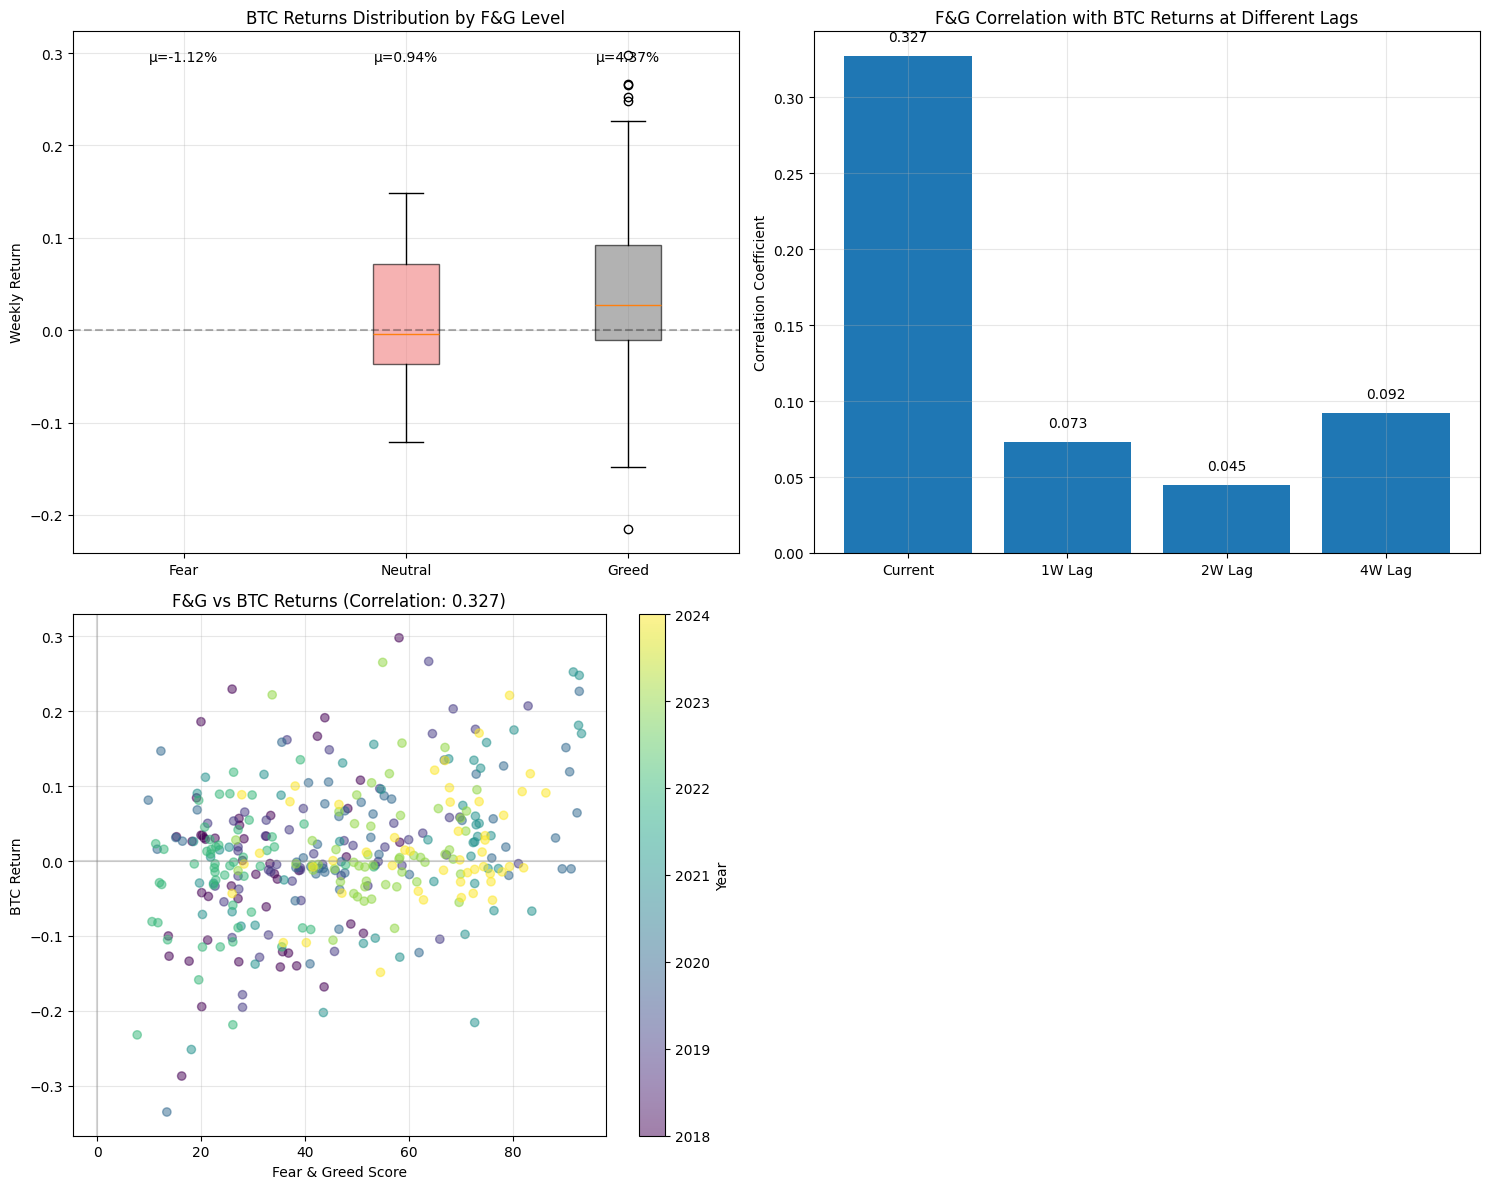

In [72]:
def plot_fear_greed_analysis(weekly_metrics, figsize=(15, 12)):
    """Analyze Fear & Greed indicators and their relationship with BTC returns"""
    
    # First print F&G classification distribution
    print("\nFear & Greed Classification Distribution:")
    print(weekly_metrics['fg_class_avg'].describe())
    print("\nValue counts:")
    print(weekly_metrics['fg_class_avg'].value_counts().sort_index())
    
    # Adjust thresholds based on actual data distribution
    fear_threshold = weekly_metrics['fg_class_avg'].quantile(0.2)  # bottom 20%
    greed_threshold = weekly_metrics['fg_class_avg'].quantile(0.8)  # top 20%
    
    print(f"\nAdjusted thresholds:")
    print(f"Fear threshold (20th percentile): {fear_threshold:.2f}")
    print(f"Greed threshold (80th percentile): {greed_threshold:.2f}")
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)
    
    # 1. Returns during extreme F&G (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Create return distributions with adjusted thresholds
    fear = weekly_metrics[weekly_metrics['fg_class_avg'] < -0.2]['btc_return']
    neutral = weekly_metrics[(weekly_metrics['fg_class_avg'] >= -0.2) & 
                            (weekly_metrics['fg_class_avg'] <= 0.2)]['btc_return']
    greed = weekly_metrics[weekly_metrics['fg_class_avg'] > 0.2]['btc_return']

    
    # Print sizes of each group
    # print("\nSample sizes:")
    # print(f"Extreme Fear periods: {len(extreme_fear)}")
    # print(f"Moderate Fear periods: {len(moderate_fear)}")
    # print(f"Neutral periods: {len(neutral)}")
    # print(f"Extreme Greed periods: {len(extreme_greed)}")
    
    # Create box plots
    data = [fear, neutral, greed]
    labels = ['Fear', 'Neutral', 'Greed']
    
    bp = ax1.boxplot(data, labels=labels, patch_artist=True)
    
    # Color the boxes
    colors = ['darkred', 'lightcoral', 'gray', 'darkgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_title('BTC Returns Distribution by F&G Level')
    ax1.set_ylabel('Weekly Return')
    ax1.grid(True, alpha=0.3)
    
    # Add mean values on top
    means = [d.mean() for d in data]
    for i, mean in enumerate(means):
        ax1.text(i+1, ax1.get_ylim()[1]*0.9, f'μ={mean:.2%}', ha='center')
    
    # 2. Lagged Correlations (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    
    lag_cols = ['fg_avg', 'fg_avg_lag1w', 'fg_avg_lag2w', 'fg_avg_lag4w']
    lag_corrs = [weekly_metrics['btc_return'].corr(weekly_metrics[col]) for col in lag_cols]
    
    bars = ax2.bar(range(len(lag_cols)), lag_corrs)
    ax2.set_xticks(range(len(lag_cols)))
    ax2.set_xticklabels(['Current', '1W Lag', '2W Lag', '4W Lag'])
    ax2.set_title('F&G Correlation with BTC Returns at Different Lags')
    ax2.set_ylabel('Correlation Coefficient')
    ax2.grid(True, alpha=0.3)
    
    # Add correlation values on top of bars
    for i, v in enumerate(lag_corrs):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    # 3. Scatter of F&G vs Returns (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    scatter = ax3.scatter(weekly_metrics['fg_avg'], 
                         weekly_metrics['btc_return'],
                         alpha=0.5,
                         c=weekly_metrics.index.year,
                         cmap='viridis')
    
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    
    corr = weekly_metrics['fg_avg'].corr(weekly_metrics['btc_return'])
    ax3.set_title(f'F&G vs BTC Returns (Correlation: {corr:.3f})')
    ax3.set_xlabel('Fear & Greed Score')
    ax3.set_ylabel('BTC Return')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, label='Year')
    
    # 4. Empty plot (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
plot_fear_greed_analysis(weekly_metrics)


Extreme Sentiment Analysis:
--------------------------------------------------
Extreme Fear periods: 55
Extreme Greed periods: 42

Extreme Fear avg return: -2.56%
Extreme Greed avg return: 6.76%


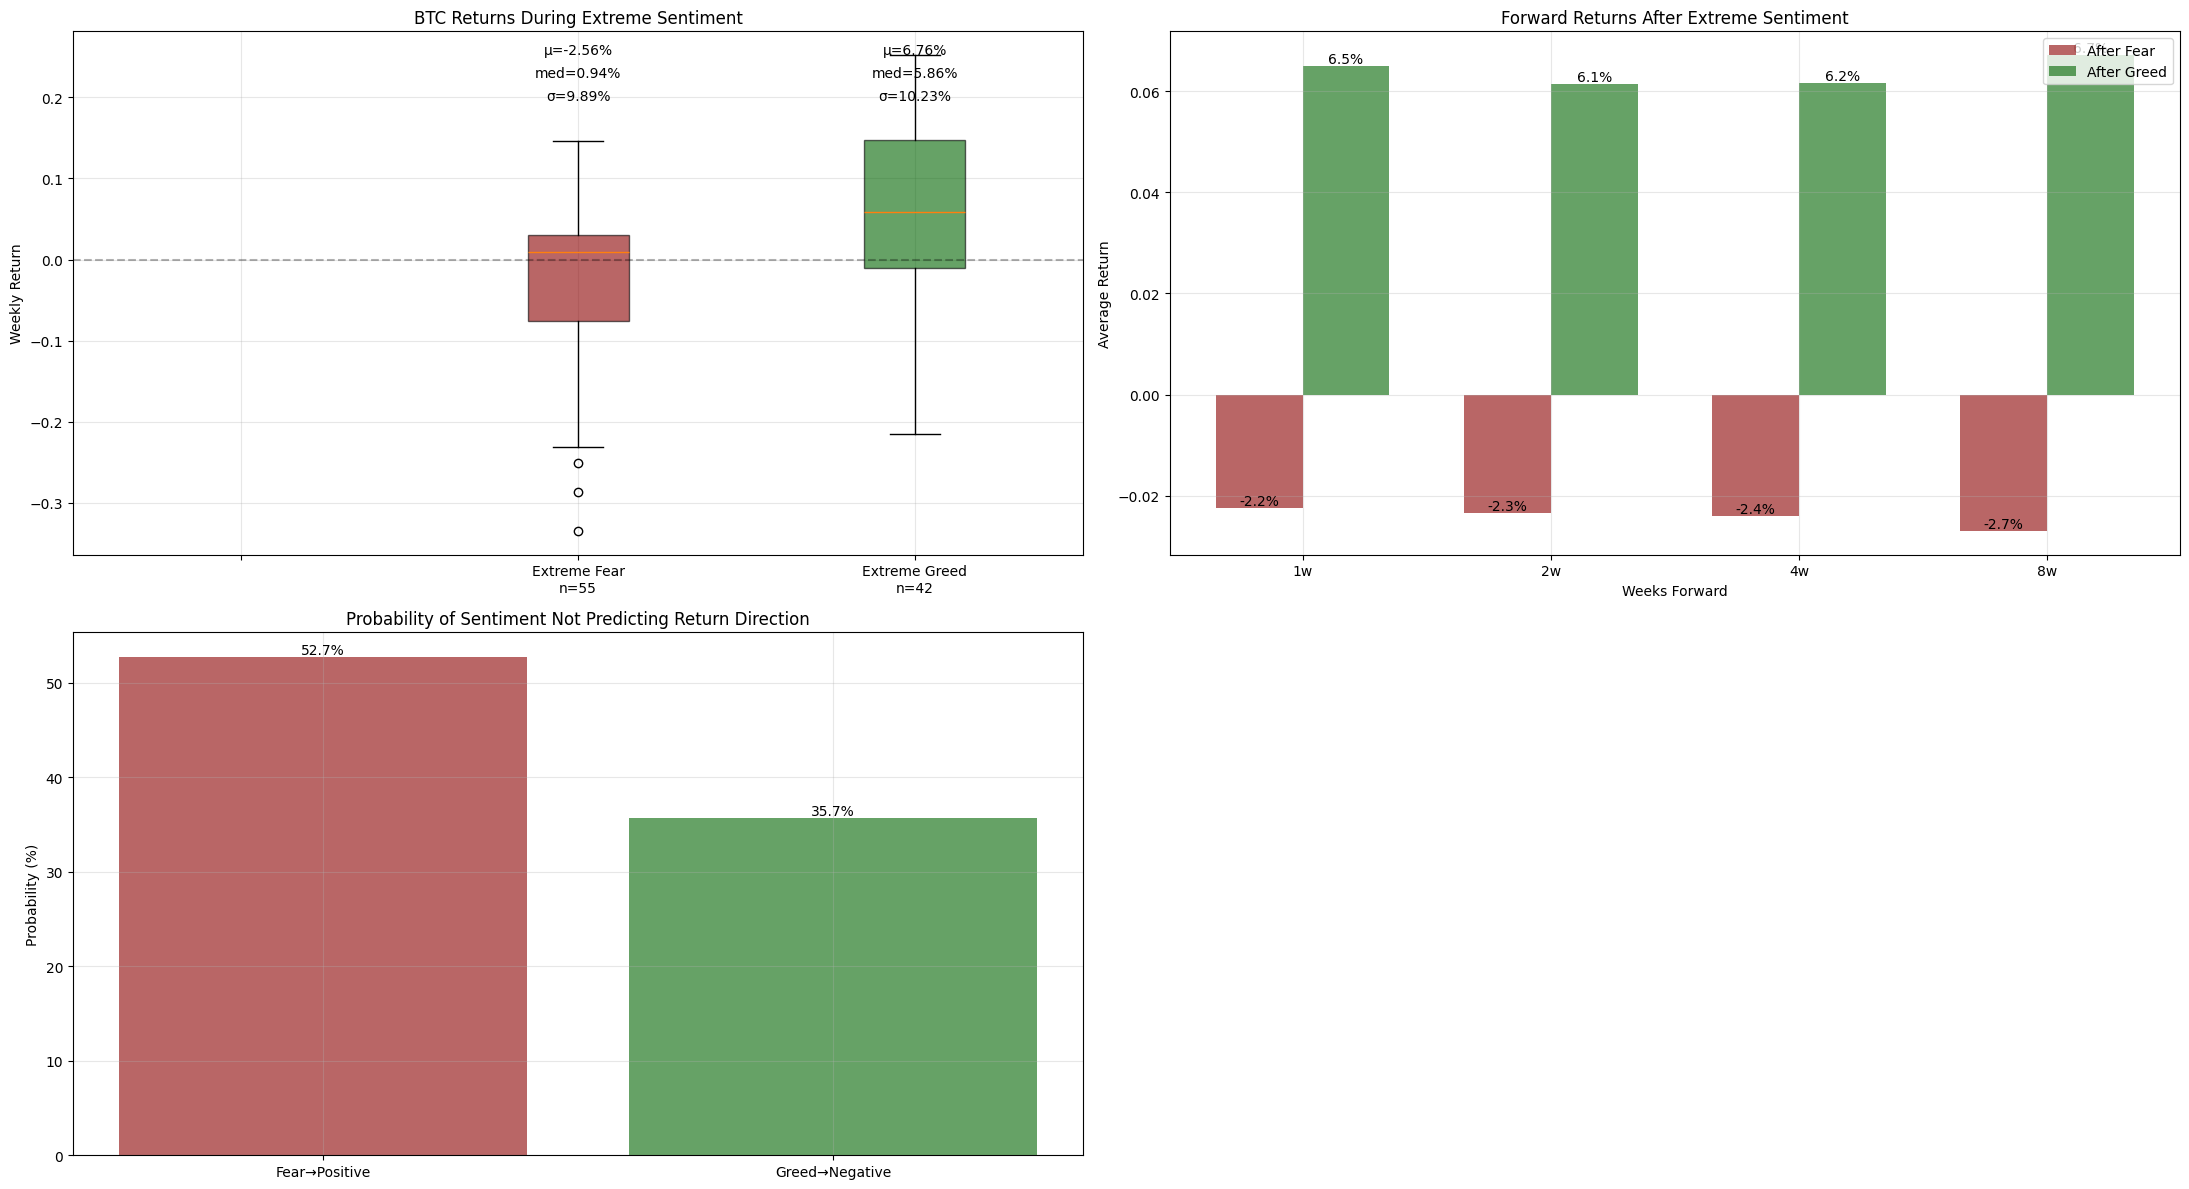

In [77]:
def plot_extreme_sentiment_analysis(weekly_metrics, figsize=(22, 12)):
    """Analyze BTC returns during extreme sentiment periods with probability analysis"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)
    
    # 1. Returns during extreme sentiment (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Get 10% most extreme readings in each direction
    extreme_fear = weekly_metrics[weekly_metrics['fg_class_avg'] <= weekly_metrics['fg_class_avg'].quantile(0.10)]['btc_return']
    extreme_greed = weekly_metrics[weekly_metrics['fg_class_avg'] >= weekly_metrics['fg_class_avg'].quantile(0.90)]['btc_return']
    
    # Create dummy data for first position
    dummy = pd.Series([0])
    
    # Print sizes and stats of each group
    print("\nExtreme Sentiment Analysis:")
    print("-" * 50)
    print(f"Extreme Fear periods: {len(extreme_fear)}")
    print(f"Extreme Greed periods: {len(extreme_greed)}")
    print(f"\nExtreme Fear avg return: {extreme_fear.mean():.2%}")
    print(f"Extreme Greed avg return: {extreme_greed.mean():.2%}")
    
    # Create box plots with dummy first
    data = [dummy, extreme_fear, extreme_greed]
    labels = ['', f'Extreme Fear\nn={len(extreme_fear)}', 
                 f'Extreme Greed\nn={len(extreme_greed)}']
    
    bp = ax1.boxplot(data, labels=labels, patch_artist=True)
    
    # Color the boxes (skip the dummy)
    colors = ['white', 'darkred', 'darkgreen']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    # Hide the dummy box
    bp['boxes'][0].set_alpha(0)
    bp['medians'][0].set_alpha(0)
    bp['whiskers'][0].set_alpha(0)
    bp['whiskers'][1].set_alpha(0)
    bp['caps'][0].set_alpha(0)
    bp['caps'][1].set_alpha(0)
    bp['fliers'][0].set_alpha(0)
    
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)
    ax1.set_title('BTC Returns During Extreme Sentiment')
    ax1.set_ylabel('Weekly Return')
    ax1.grid(True, alpha=0.3)
    
    # Add mean and median values (skip dummy)
    real_data = [extreme_fear, extreme_greed]
    for i, d in enumerate(real_data, 2):
        mean = d.mean()
        median = d.median()
        std = d.std()
        ax1.text(i, ax1.get_ylim()[1]*0.9, f'μ={mean:.2%}', ha='center')
        ax1.text(i, ax1.get_ylim()[1]*0.8, f'med={median:.2%}', ha='center')
        ax1.text(i, ax1.get_ylim()[1]*0.7, f'σ={std:.2%}', ha='center')
    
    # 2. Forward returns analysis (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    
    forward_periods = [1, 2, 4, 8]  # weeks forward
    fear_forward_returns = []
    greed_forward_returns = []
    
    for weeks in forward_periods:
        fear_forward = weekly_metrics[weekly_metrics['fg_class_avg'] <= weekly_metrics['fg_class_avg'].quantile(0.10)]['btc_return'].shift(-weeks)
        fear_forward_returns.append(fear_forward.mean())
        
        greed_forward = weekly_metrics[weekly_metrics['fg_class_avg'] >= weekly_metrics['fg_class_avg'].quantile(0.90)]['btc_return'].shift(-weeks)
        greed_forward_returns.append(greed_forward.mean())
    
    x = np.arange(len(forward_periods))
    width = 0.35
    
    ax2.bar(x - width/2, fear_forward_returns, width, label='After Fear', color='darkred', alpha=0.6)
    ax2.bar(x + width/2, greed_forward_returns, width, label='After Greed', color='darkgreen', alpha=0.6)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{w}w' for w in forward_periods])
    ax2.set_title('Forward Returns After Extreme Sentiment')
    ax2.set_xlabel('Weeks Forward')
    ax2.set_ylabel('Average Return')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add values on top of bars
    for i, v in enumerate(fear_forward_returns):
        ax2.text(i - width/2, v, f'{v:.1%}', ha='center', va='bottom')
    for i, v in enumerate(greed_forward_returns):
        ax2.text(i + width/2, v, f'{v:.1%}', ha='center', va='bottom')
    
    # 3. Probability Analysis (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Calculate probabilities of return direction not matching sentiment
    fear_wrong = (extreme_fear > 0).mean() * 100  # % of time returns positive during fear
    greed_wrong = (extreme_greed < 0).mean() * 100  # % of time returns negative during greed
    
    probabilities = [fear_wrong, greed_wrong]
    labels = ['Fear→Positive', 'Greed→Negative']
    
    bars = ax3.bar(labels, probabilities, color=['darkred', 'darkgreen'], alpha=0.6)
    ax3.set_title('Probability of Sentiment Not Predicting Return Direction')
    ax3.set_ylabel('Probability (%)')
    ax3.grid(True, alpha=0.3)
    
    # Add probability values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 4. Empty plot (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
plot_extreme_sentiment_analysis(weekly_metrics)

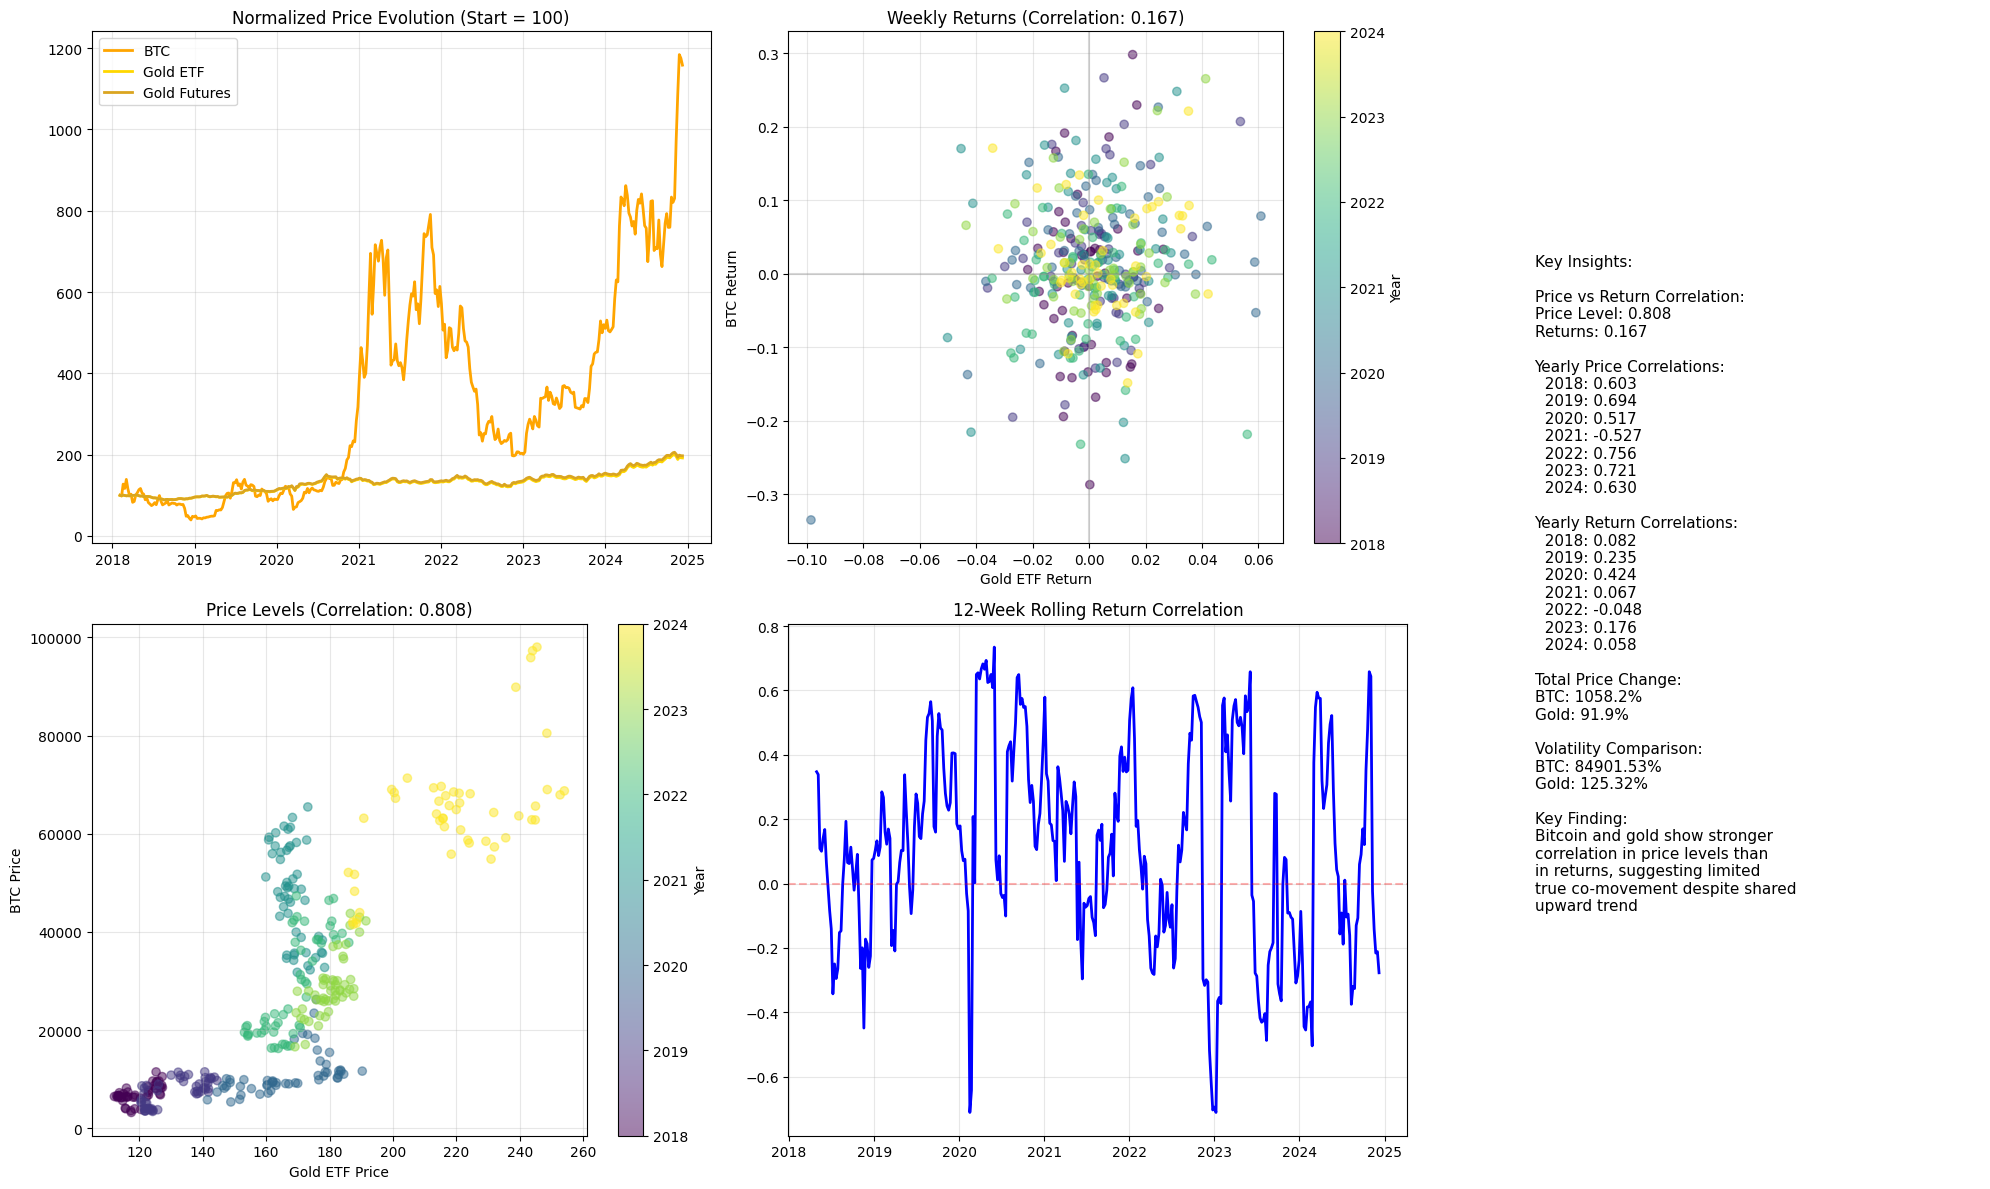

In [61]:
def plot_btc_gold_insights(weekly_metrics, figsize=(20, 12)):
    """Compare BTC with gold instruments at both price levels and returns"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 3, width_ratios=[1, 1, 0.8])
    
    # 1. Normalized Price Evolution (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Normalize all prices to start at 100
    btc_norm = weekly_metrics['btc_close'] / weekly_metrics['btc_close'].iloc[0] * 100
    gold_etf_norm = weekly_metrics['gold_etf_avg'] / weekly_metrics['gold_etf_avg'].iloc[0] * 100
    gold_fut_norm = weekly_metrics['gold_fut_avg'] / weekly_metrics['gold_fut_avg'].iloc[0] * 100
    
    ax1.plot(weekly_metrics.index, btc_norm, label='BTC', color='orange', linewidth=2)
    ax1.plot(weekly_metrics.index, gold_etf_norm, label='Gold ETF', color='gold', linewidth=2)
    ax1.plot(weekly_metrics.index, gold_fut_norm, label='Gold Futures', color='goldenrod', linewidth=2)
    
    ax1.set_title('Normalized Price Evolution (Start = 100)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Price Levels Scatter (bottom left)
    ax2 = fig.add_subplot(gs[1, 0])
    scatter1 = ax2.scatter(weekly_metrics['gold_etf_avg'], 
                          weekly_metrics['btc_close'],
                          alpha=0.5,
                          c=weekly_metrics.index.year,
                          cmap='viridis')
    
    corr_price = weekly_metrics['gold_etf_avg'].corr(weekly_metrics['btc_close'])
    ax2.set_title(f'Price Levels (Correlation: {corr_price:.3f})')
    ax2.set_xlabel('Gold ETF Price')
    ax2.set_ylabel('BTC Price')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=ax2, label='Year')
    
    # 3. Returns Scatter (top right)
    ax3 = fig.add_subplot(gs[0, 1])
    scatter2 = ax3.scatter(weekly_metrics['gold_etf_return'], 
                          weekly_metrics['btc_return'],
                          alpha=0.5,
                          c=weekly_metrics.index.year,
                          cmap='viridis')
    
    corr_return = weekly_metrics['gold_etf_return'].corr(weekly_metrics['btc_return'])
    ax3.set_title(f'Weekly Returns (Correlation: {corr_return:.3f})')
    ax3.set_xlabel('Gold ETF Return')
    ax3.set_ylabel('BTC Return')
    ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.3)
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=ax3, label='Year')
    
    # 4. Rolling Return Correlation (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    rolling_return_corr = weekly_metrics['btc_return'].rolling(12).corr(weekly_metrics['gold_etf_return'])
    ax4.plot(weekly_metrics.index, rolling_return_corr, color='blue', linewidth=2)
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.3)
    ax4.set_title('12-Week Rolling Return Correlation')
    ax4.grid(True, alpha=0.3)
    
    # 5. Text findings (right panel)
    ax5 = fig.add_subplot(gs[:, 2])
    ax5.axis('off')
    
    # Calculate key statistics
    yearly_price_corrs = {}
    yearly_return_corrs = {}
    for year in weekly_metrics.index.year.unique():
        mask = weekly_metrics.index.year == year
        yearly_price_corrs[year] = weekly_metrics.loc[mask, 'btc_close'].corr(
            weekly_metrics.loc[mask, 'gold_etf_avg'])
        yearly_return_corrs[year] = weekly_metrics.loc[mask, 'btc_return'].corr(
            weekly_metrics.loc[mask, 'gold_etf_return'])
    
    btc_total_return = (btc_norm.iloc[-1] - 100)
    gold_total_return = (gold_etf_norm.iloc[-1] - 100)
    
    findings = [
        "Key Insights:",
        "",
        "Price vs Return Correlation:",
        f"Price Level: {corr_price:.3f}",
        f"Returns: {corr_return:.3f}",
        "",
        "Yearly Price Correlations:",
        *[f"  {year}: {corr:.3f}" for year, corr in yearly_price_corrs.items()],
        "",
        "Yearly Return Correlations:",
        *[f"  {year}: {corr:.3f}" for year, corr in yearly_return_corrs.items()],
        "",
        "Total Price Change:",
        f"BTC: {btc_total_return:.1f}%",
        f"Gold: {gold_total_return:.1f}%",
        "",
        "Volatility Comparison:",
        f"BTC: {weekly_metrics['btc_std'].mean():.2%}",
        f"Gold: {weekly_metrics['gold_etf_std'].mean():.2%}",
        "",
        "Key Finding:",
        "Bitcoin and gold show stronger",
        "correlation in price levels than",
        "in returns, suggesting limited",
        "true co-movement despite shared",
        "upward trend"
    ]
    
    ax5.text(0.1, 0.5, '\n'.join(findings), 
             fontsize=11, 
             verticalalignment='center',
             fontfamily='sans-serif')
    
    plt.tight_layout()
    plt.show()
    
plot_btc_gold_insights(weekly_metrics)


Fear Data Statistics:
--------------------------------------------------
Number of fear periods: 214
Mean return: -0.0107
Median return: -0.0051
Std dev: 0.0873

Quartiles:
count    213.000000
mean      -0.010666
std        0.087332
min       -0.334948
25%       -0.052736
50%       -0.005067
75%        0.032396
max        0.229381
Name: btc_return, dtype: float64


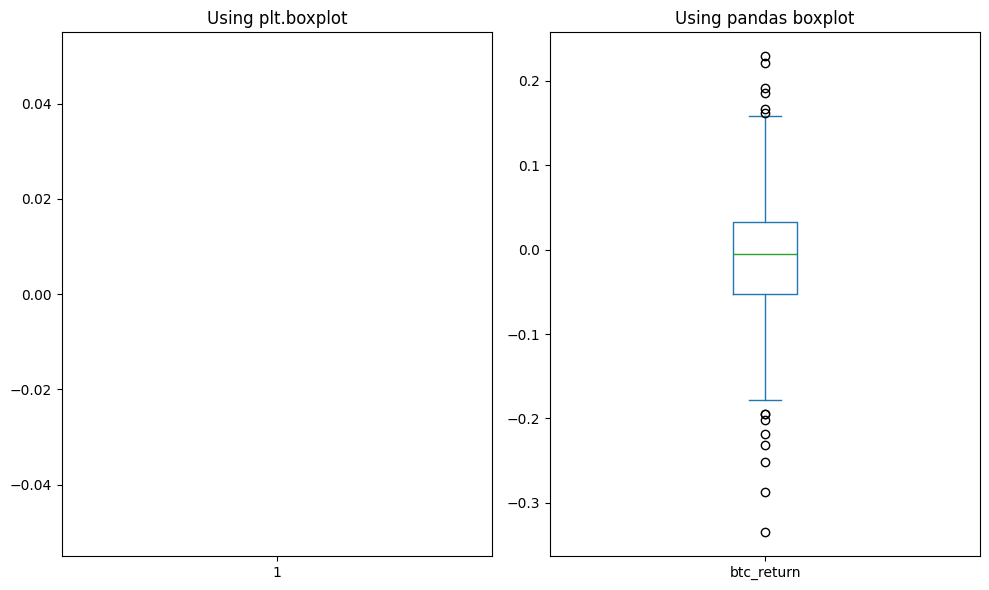


First few values:
timestamp
2018-02-04         NaN
2018-02-11   -0.017765
2018-02-25   -0.084068
2018-03-04    0.191197
2018-03-11   -0.167987
Name: btc_return, dtype: float64

Data type: float64

Null values: 1
Infinite values: 1


In [68]:
def debug_fear_greed(weekly_metrics):
    """Debug function to examine fear data"""
    
    # First look at the actual data
    fear_data = weekly_metrics[weekly_metrics['fg_class_avg'] <= 0]['btc_return']
    
    print("\nFear Data Statistics:")
    print("-" * 50)
    print(f"Number of fear periods: {len(fear_data)}")
    print(f"Mean return: {fear_data.mean():.4f}")
    print(f"Median return: {fear_data.median():.4f}")
    print(f"Std dev: {fear_data.std():.4f}")
    print("\nQuartiles:")
    print(fear_data.describe())
    
    # Create simple figure with just one box plot
    plt.figure(figsize=(10, 6))
    
    # Try both methods
    plt.subplot(1, 2, 1)
    plt.boxplot(fear_data)
    plt.title('Using plt.boxplot')
    
    plt.subplot(1, 2, 2)
    fear_data.plot(kind='box')
    plt.title('Using pandas boxplot')
    
    plt.tight_layout()
    plt.show()
    
    # Print the first few values to verify data type
    print("\nFirst few values:")
    print(fear_data.head())
    print("\nData type:", fear_data.dtype)
    
    # Check for any potential issues
    print("\nNull values:", fear_data.isnull().sum())
    print("Infinite values:", (~np.isfinite(fear_data)).sum())
debug_fear_greed(weekly_metrics)

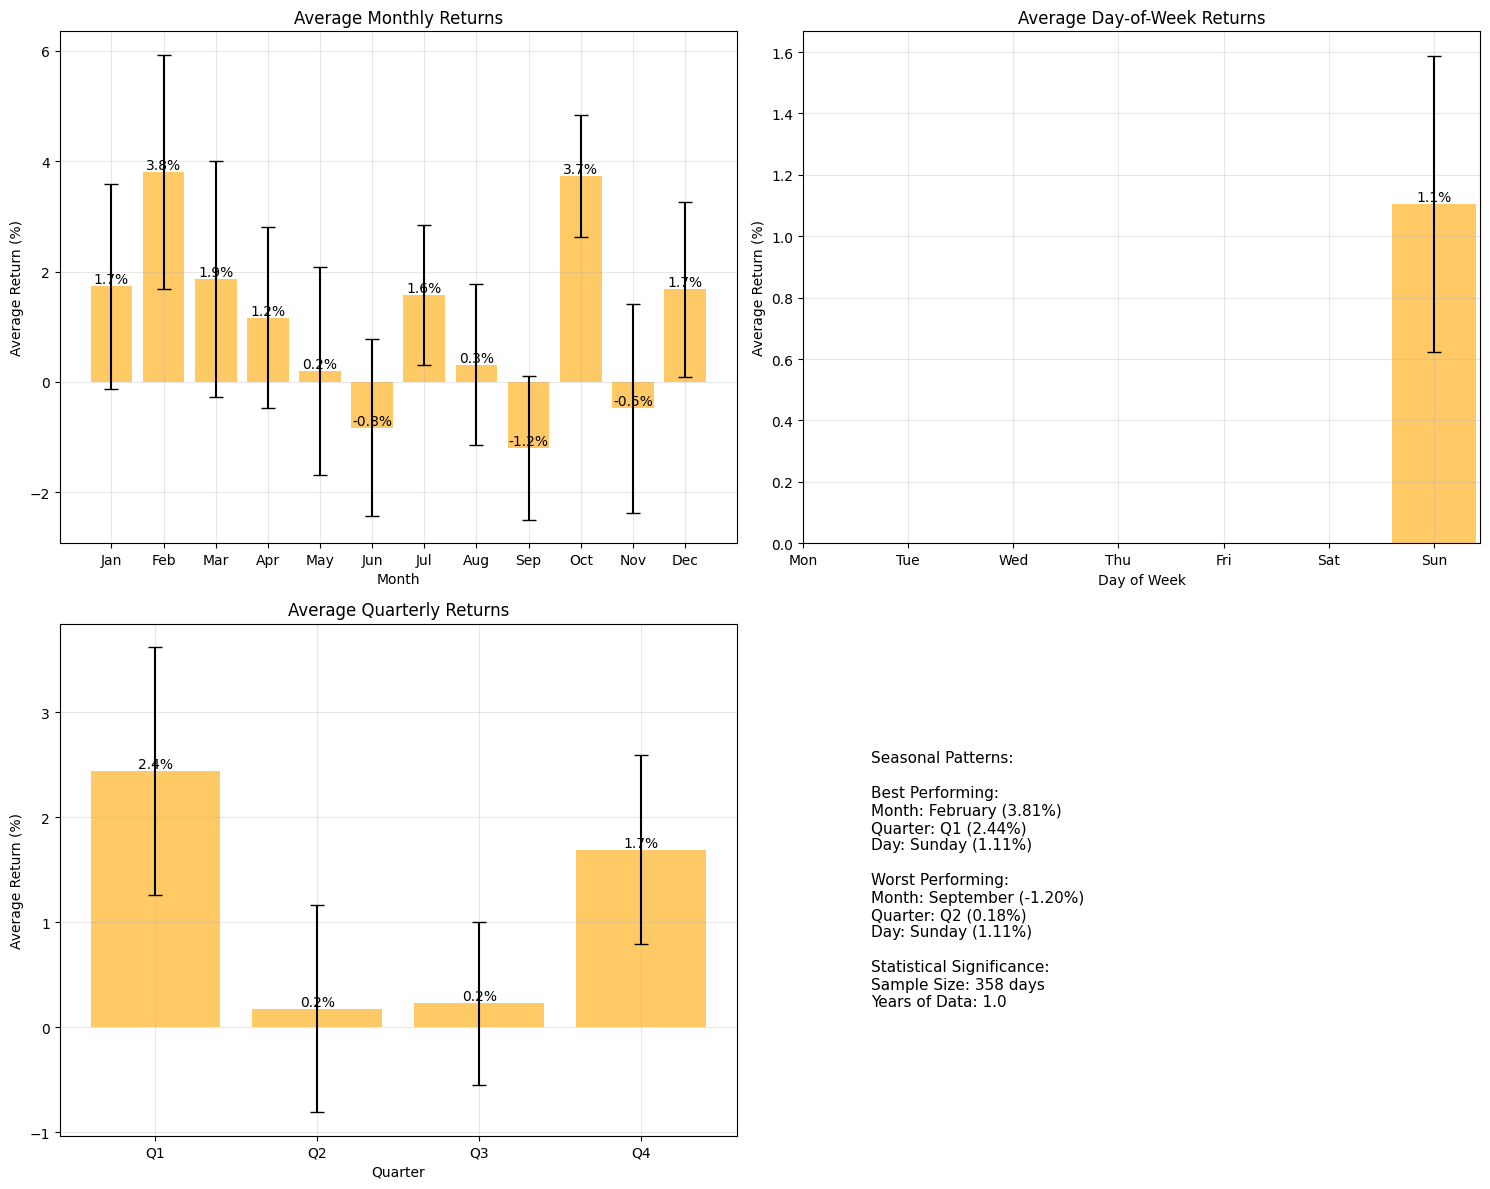


Seasonal Pattern Statistics:
--------------------------------------------------

Monthly Returns:
month
2     0.038074
10    0.037328
3     0.018652
1     0.017330
12    0.016768
7     0.015714
4     0.011639
8     0.003111
5     0.001912
11   -0.004805
6    -0.008286
9    -0.011967
Name: mean, dtype: float64

Quarterly Returns:
quarter
1    0.024401
4    0.016900
3    0.002277
2    0.001757
Name: mean, dtype: float64

Day of Week Returns:
dayofweek
6    0.011058
Name: mean, dtype: float64


In [85]:
def plot_btc_seasonality(weekly_metrics, figsize=(15, 12)):
    """Analyze BTC seasonal patterns across different timeframes"""
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)
    
    # 1. Monthly Returns (top left)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Calculate average returns by month
    weekly_metrics['month'] = weekly_metrics.index.month
    monthly_returns = weekly_metrics.groupby('month')['btc_return'].agg(['mean', 'std', 'count'])
    
    bars = ax1.bar(monthly_returns.index, monthly_returns['mean'] * 100,
                   alpha=0.6, color='orange')
    
    # Add error bars (standard error)
    std_error = monthly_returns['std'] / np.sqrt(monthly_returns['count'])
    ax1.errorbar(monthly_returns.index, monthly_returns['mean'] * 100,
                 yerr=std_error * 100, fmt='none', color='black', capsize=5)
    
    ax1.set_title('Average Monthly Returns')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Average Return (%)')
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax1.grid(True, alpha=0.3)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 2. Day of Week Analysis (top right)
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Calculate average returns by day of week
    weekly_metrics['dayofweek'] = weekly_metrics.index.dayofweek
    dow_returns = weekly_metrics.groupby('dayofweek')['btc_return'].agg(['mean', 'std', 'count'])
    
    bars = ax2.bar(dow_returns.index, dow_returns['mean'] * 100,
                   alpha=0.6, color='orange')
    
    # Add error bars
    std_error = dow_returns['std'] / np.sqrt(dow_returns['count'])
    ax2.errorbar(dow_returns.index, dow_returns['mean'] * 100,
                 yerr=std_error * 100, fmt='none', color='black', capsize=5)
    
    ax2.set_title('Average Day-of-Week Returns')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Average Return (%)')
    ax2.set_xticks(range(7))
    ax2.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax2.grid(True, alpha=0.3)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 3. Quarterly Performance (bottom left)
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Calculate average returns by quarter
    weekly_metrics['quarter'] = weekly_metrics.index.quarter
    quarterly_returns = weekly_metrics.groupby(['quarter'])['btc_return'].agg(['mean', 'std', 'count'])
    
    bars = ax3.bar(quarterly_returns.index, quarterly_returns['mean'] * 100,
                   alpha=0.6, color='orange')
    
    # Add error bars
    std_error = quarterly_returns['std'] / np.sqrt(quarterly_returns['count'])
    ax3.errorbar(quarterly_returns.index, quarterly_returns['mean'] * 100,
                 yerr=std_error * 100, fmt='none', color='black', capsize=5)
    
    ax3.set_title('Average Quarterly Returns')
    ax3.set_xlabel('Quarter')
    ax3.set_ylabel('Average Return (%)')
    ax3.set_xticks(range(1, 5))
    ax3.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
    ax3.grid(True, alpha=0.3)
    
    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # 4. Additional Stats (bottom right)
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    # Calculate best/worst periods
    best_month = monthly_returns['mean'].idxmax()
    worst_month = monthly_returns['mean'].idxmin()
    best_quarter = quarterly_returns['mean'].idxmax()
    worst_quarter = quarterly_returns['mean'].idxmin()
    best_day = dow_returns['mean'].idxmax()
    worst_day = dow_returns['mean'].idxmin()
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    months = ['January', 'February', 'March', 'April', 'May', 'June',
              'July', 'August', 'September', 'October', 'November', 'December']
    
    stats_text = [
        "Seasonal Patterns:",
        "",
        "Best Performing:",
        f"Month: {months[best_month-1]} ({monthly_returns.loc[best_month, 'mean']:.2%})",
        f"Quarter: Q{best_quarter} ({quarterly_returns.loc[best_quarter, 'mean']:.2%})",
        f"Day: {days[best_day]} ({dow_returns.loc[best_day, 'mean']:.2%})",
        "",
        "Worst Performing:",
        f"Month: {months[worst_month-1]} ({monthly_returns.loc[worst_month, 'mean']:.2%})",
        f"Quarter: Q{worst_quarter} ({quarterly_returns.loc[worst_quarter, 'mean']:.2%})",
        f"Day: {days[worst_day]} ({dow_returns.loc[worst_day, 'mean']:.2%})",
        "",
        "Statistical Significance:",
        f"Sample Size: {len(weekly_metrics)} days",
        f"Years of Data: {len(weekly_metrics)/365:.1f}"
    ]
    
    ax4.text(0.1, 0.5, '\n'.join(stats_text),
             fontsize=11,
             verticalalignment='center',
             fontfamily='sans-serif')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional insights
    print("\nSeasonal Pattern Statistics:")
    print("-" * 50)
    print("\nMonthly Returns:")
    print(monthly_returns['mean'].sort_values(ascending=False))
    print("\nQuarterly Returns:")
    print(quarterly_returns['mean'].sort_values(ascending=False))
    print("\nDay of Week Returns:")
    print(dow_returns['mean'].sort_values(ascending=False))

plot_btc_seasonality(weekly_metrics)

## Key Insights:

### Price Level Correlation: 0.808

### Yearly Price Correlations:
- 2018: 0.603
- 2019: 0.694
- 2020: 0.517
- 2021: -0.527
- 2022: 0.756
- 2023: 0.721
- 2024: 0.630

### Return Correlations:
- 2018: 0.082
- 2019: 0.235
- 2020: 0.424
- 2021: 0.067
- 2022: -0.048
- 2023: 0.176
- 2024: 0.058

### Total Price Change:
- BTC: 1058.2%
- Gold: 91.9%

### Volatility Comparison:
- BTC: 84901.53%
- Gold: 125.32%

### Key Finding:
Price correlation appears stronger than return correlation due to shared upward trend, but true co-movement is limited.


In [81]:
weekly_metrics

,fg_avg,fg_range,fg_class_avg,fg_extreme_pct,fg_avg_lag1w,fg_class_avg_lag1w,fg_avg_lag2w,fg_class_avg_lag2w,fg_avg_lag4w,fg_class_avg_lag4w,...,btc_range,btc_std,btc_return_2w,btc_return_4w,gold_btc_ratio,volume_price_ratio,funding_volume_ratio,month,dayofweek,quarter
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-02-04,27.250000,25.0,-1.500000,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,...,897.900390,422.805342,NaN,NaN,0.015330,17.430896,0.000000e+00,2,6,1
2018-02-11,30.571429,46.0,-1.142857,0.285714,27.250000,-1.500000,NaN,NaN,NaN,NaN,...,1781.710449,620.710439,NaN,NaN,0.015406,41.918271,0.000000e+00,2,6,1
2018-02-18,58.142857,39.0,0.428571,0.000000,30.571429,-1.142857,27.250000,-1.500000,NaN,NaN,...,2514.390630,901.626832,0.274832,NaN,0.012058,29.555438,0.000000e+00,2,6,1
2018-02-25,48.857143,43.0,-0.285714,0.000000,58.142857,0.428571,30.571429,-1.142857,NaN,NaN,...,1738.969731,684.426602,0.188778,NaN,0.013061,36.278625,0.000000e+00,2,6,1
2018-03-04,43.857143,19.0,-0.571429,0.000000,48.857143,-0.285714,58.142857,0.428571,27.250000,-1.500000,...,1145.899410,468.996856,0.091056,0.390913,0.010886,15.979970,0.000000e+00,3,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-10,73.571429,8.0,1.285714,0.285714,74.142857,1.285714,71.333333,0.857143,45.428571,-0.285714,...,12662.679690,4460.054727,0.184676,0.280389,0.003088,4.068946,1.769172e-09,11,6,4
2024-11-17,83.428571,14.0,2.000000,1.000000,73.571429,1.285714,74.142857,1.285714,67.857143,0.857143,...,3815.578120,1466.809041,0.307018,0.302082,0.002657,4.648298,1.991802e-09,11,6,4
2024-11-24,86.428571,14.0,2.000000,1.000000,83.428571,2.000000,73.571429,1.285714,71.333333,0.857143,...,8455.023430,3368.199807,0.217954,0.442880,0.002504,3.099408,3.053698e-09,11,6,4
